# Deep Dive into EM, Guassian Mixture Models and KMeans



## 1. Introduction

Goals

* Give Intuition
* Mathemathical Rigor for the adventurous readers.
* Examples
* Advantage of K-means 
  * better classification
  * reduce size
  * visualization
* Alternatives to Kmeans
* Ref  

## 2. KMeans Clustering

##### 2.0. Why KMeans naturally arises!

In real life, the data is generated from fixed degree of freedom and when we collect data, there are noise added or sometimes we don't know the actual dimensions . These all means that to represent a collection of data, we use a lot of memory for datasets. But since in real life , data is generated from a set of fixed categories meaning that there is bound to have some duplications of the data points and if we can only store a few representative points in each category, we can seperately analyse, each of the those category or cluster and gain deeper insights. For example, as a person, you would like to manage and categorize your expenses. You might spend money on turkey sandwich, chicken sandwitch, rent, car oil changes, car brake fixes etc. But technically, there are only 3 categories in above example i.e food expense, car expense, rent expense. Thus if we can somehow cluster the data set into more natural categories, we can get a lot more insights and better pruning for the datasets. 
This notebook will explore those areas.

##### 2.1. What is KMeans clustering.

Given a datasets, we usually build our models from the labelled datasets aka supervised learning techniques. On the other side, K-means clustering is an unsupervized learning techniques meaning, we don't need a labelled datasets. That way, we save efforts for labelling.

Later we will see that K-means is a special case of Guassian Mixture models and Expectation Maximization. 

For now, lets look at the steps involved in k-means. It is a simple algorithm to classify datasets into k clusters. 

1. Randomly assign k points as the potential centroid (similar to weighted center).
  (Note: We will see later what is the best way to assign the initial center)

2. Take each point in dataset and assign and associate it to the nearest centeroid.

3. Re-calculate the centroid with the points in the cluster.

4. Repeat steps 2-3, until the centroid locations changes very little from the previous iterations.


##### 2.2. Why is KMeans useful?


* Clustering algorithms with better features tend to be more expensive computationally compare to k-means and hence it is much faster in runtime.

* It is better for high dimensional data.

* Clusters have natural meanings and it is easy to implement.

* k-means is use as a pre-clustering algorithm reducing the space into smaller sub-spaces, were each smaller sub-spaces can be analysed.



##### 2.3 Intuition of K-means.

The intuition behind K-means clustering is remarkably simple. 

If we don't know the answers to how to make optimum k clusters, then we make our best guess i.e our best estimation by initializing the center of the clusters and we then go over the data points and then ask ourself, where does it belongs and we temporarily assign datapoint to one of he clusters. This is what we call expectation step. 

Now, we refine our clusters by recomputing the centroid of each cluster and this step is called maximization step.



## 3. Mathemathical formulation

Now, lets derive the expression for k-means by rigourous mathemathical methods.


In [1]:


import time

# load high performance linalg lib
import numpy as np

import scipy as sp

import sklearn 

# pandas util
import pandas as pd

# load PCA
from sklearn.decomposition import  PCA, KernelPCA
from sklearn.cluster import KMeans

from sklearn import preprocessing

# load util for datasets
from sklearn import datasets

# load StandardScalar i.e shift by mean and scale by standard deviation
from sklearn.preprocessing import StandardScaler


# for visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.feature_extraction import image
from sklearn.datasets import load_sample_image
from sklearn.metrics import accuracy_score

# mvn
from scipy.stats import multivariate_normal as mvn



#animation
from matplotlib import animation

from mpl_toolkits.mplot3d import Axes3D


from matplotlib import colors




In [2]:
# to make sure that notebooks are plotting 

#%matplotlib notebook

%matplotlib notebook

Let define some of the terms, before we move forward

##### 3.1 Convention used


| Symbol        | description                                                 |
|:--------------|:------------------------------------------------------------|
| $x_{4}$       | scaler is represented as lowercase with dimension subscript |
| $\mathbf{x}$  | vector is represented as a bold lowercase                   |
| $\mathbf{X}$  | matrix is represented as bold uppercase                     |
| $\mathbf{X}$  | matrix is represented as bold uppercase                     |
| $RV$          | random variable is represented by uppercase                 |
| $rv$          | a sample of random variable is represented by lowercase     |
| $\mathbf{RV}$ | vector of random variable is represented by uppercase|
| $\mathbf{rv}$ | a vector sample of vector of random variable is represented by uppercase|

##### 3.2. Linear Algebra

To represent many data points and compactly manupulate it's operations linear algebra is an excellent tool. We recommend this excellent [book by Gibert Strang](https://www.amazon.com/Introduction-Linear-Algebra-Fourth-Gilbert/dp/0980232716) and/or [wiki](https://en.wikipedia.org/wiki/Linear_algebra). We will cover a small portion relevant to current topic.



##### 3.2.1. Scalar variable.

When we collect data each of the measurement is scalar. We could collect N samples of each scalar.


###### 3.2.2. Vector variable.

During data collection, we might measure various attributes, for example age, gender etc of the test subject.
to compactly represent M scalars for each subject, vector is used, it is just a tuple of M scalars and uniquely describes a point in M dimensional space.

(**Note**: We use Transpose operation to compactly represent column vector as row)

(**Note**: A vector is a point in M dimensional space)


###### Represenation of a sample using vector
Let the original input dataset be represented by M number of dimensions i.e each sample consist of M different 1D data point and together they form a sample data point column vector. $\mathbf{x}  = (x_{1}, x_{2} \cdots x_{d})^{T}$. 


Since we will be having N different data point, we would like to suffix $ i $ for the ith sample and the ith data point vector is 
$$ \mathbf{x_{i}}  = (x_{i1}, x_{i2} \cdots , x_{id})^{T} $$ 


###### 3.2.3. Matrix variable.

##### Representation of Whole dataset.
As we noted in previous sub section that each subject or sample can be represented by one column vector. If we take N such measurement, we can compactly represent all those N measurements across M dimension $N \times M$ matrix.

$$ \mathbf{X} = ( \mathbf{x_{1}}^{T}, \mathbf{x_{2}}^{T}, \cdots  \mathbf{x_{i}}^{T} \cdots ,\mathbf{x_{n}}^{T} )^{T}
$$



##### 3.3 Statistics

Statistics find applications in variety of fields including Machine Learning. It is a short representation of a lot of information. We recommend this excellent [book by David Freeman](https://www.amazon.com/Statistics-4th-David-Freedman/dp/0393929728/ref=sr_1_1?s=books&ie=UTF8&qid=1539282517&sr=1-1&keywords=statistics+david+freedman+4th+edition) and/or [wiki](https://en.wikipedia.org/wiki/Statistics). We will cover a small portion relevant to current topic.

###### 3.3.1. Variance of one dimensional i.e scalar variable.


  If we takes N samples of a random variable $v$ with zero mean, then it's variance is given by 
$$variance(v) = \frac{1}{N}\sum_{i=1}^{N}v^2$$



###### 3.3.2. Standardization of data points.


If we shift each of the dimensions by it's mean then we would have standardized data. The advantage of this would be simpler math.

We would also like to divide it by dispersion i.e standard deviation because this will remove any bias associated with measuring units i.e measurement in inch vs cm etc.

it means new i'th sample is represented as $\mathbf{s_{i}}  = (s_{i1}, s_{i2} \cdots , s_{id})^{T}$ i.e a column vector of standardized dimensions $s_{ij}$

Each of the i'th samples' j'th dimension is represented as follows

$$s_{ij} = \frac{x_{ij} - \overline{x_{j}}}{ \sigma_{x_{j}}}$$


 
Where
  * Average for jth dimension $\Rightarrow  \overline{x_{j}} = \frac{1}{N}\Sigma x_{ij}$
  
  * Standard Variance for jth dimension  $\Rightarrow  \sigma_{x_{j}} = \sqrt[2]{\frac{1}{N}\sum_{i=1}^{N}(x_{ij} - \overline{x_{j}})^2}$
  
  
and new standardized data matrix of size $N \times M$ becomes 

$\mathbf{S} = ( \mathbf{s_{1}}^{T}, \mathbf{s_{2}}^{T}, \cdots  \mathbf{s_{i}}^{T} \cdots ,\mathbf{s_{n}}^{T} )^{T}$


##### 3.2.3. Covariance of M dimensional Vector.

If we collect N samples for one dimensional data, then we know that using mean and variance we can get a good perspective on data. In short, using sufficient statistics i.e mean and variance allows us to have compression and remove the noise. The natural question is what to do when we have more than one dimensions to data i.e say M dimensions. Well how about characterizing it by M mean and M variances? This seems intuitively right, but here we are assuming that there is no co-relation or co-variance between any two dimensions. What if we want to account for this? The approach would be to compute variances between two dimensions and it is called covariance. Since we have assumed without loss of generality that each dimension has zero mean. We can defined covariance between them and thus with about $MxM$ parameters, we can represent our dataset.

We will assume the dataset as described in section 3.2.4 above. Where we collect N samples for each of M dimensions.

Lets also define $\mathbf{ss_{k}}$ as the k'th column of matrix $\mathbf{S}$ i.e $\mathbf{ss_{k}}$ represents all the samples we collected for the k'th dimensions and is defined as
$$ \mathbf{ss_{k}} = (s_{1k}, s_{2k}, \cdots ,s_{nk})^{T} $$

The [Covariance Matrix](https://en.wikipedia.org/wiki/Covariance_matrix)  $M \times M$ matrix and is defined as

$$\Sigma = (\Sigma_{ij}) \in \Re^{M \times M}$$

* Each $\Sigma_{ij}$ is a covariance of ith and jth dimensions and is given by

\begin{align}
\Sigma_{ij} &= cov(\mathbf{ss_{i}}, \mathbf{ss_{j}}) \\
 &= \mathbb{E}(\mathbf{ss_{i}}, \mathbf{ss_{j}}) && \text{from the defn of covariance with zero means}\\
 &= \frac{1}{N} \sum_{m=1}^{N}(ss_{mi} \times {ss_{mj}})\\
\end{align}

Note that the above expression can be compactly represented in [covariance matrix form ](https://en.wikipedia.org/wiki/Covariance_matrix#Definition)
\begin{equation}
\begin{split}
\Sigma &= \mathbb{E}(\mathbf{s},\mathbf{s}^{T})\\
& = \frac{1}{N}\sum_{i=1}^{N}(\mathbf{s_{i}}\mathbf{s_{i}}^{T})\\
\end{split}
\end{equation}



##### 3.4 Probability Theory 

We encourage user to consult this [excellent book](https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712) and [wiki](https://en.wikipedia.org/wiki/Probability_theory) for indepth probability theory.
Here we will discuss quick overview for the topic that are relevant to the Kmeans mathemathical formulation.

###### 3.4.1. How Random Variable (RV) arises and it's measurement in terms of Probability.

In real life, we can't always pinpoints the output of the events. Event could be any action for example rolling a dice, 
picking a random person for survey and etc. However in all the cases, the number of possible outcome is fixed and hence instead of talking in concreate terms, we would like to think in terms of possibilities i.e if we roll a dice, what is the possibility that we will get a number $6$ and we know that for unbiased dice it is $\frac{1}{6}$. Just in this case outcome $X$ is a random variable and it's specific outcome i.e output 6 is one instance of random variable is usually denoted with lower case i.e $x$. It's possibilities i.e probability is measure between $0$ and $1$ and is denoted by $$p(x) = p(X=x) = p(X=6)$$.

###### 3.4.2. Joint Probability of more than one Events.

Continuing our analogy, if we roll our dice multiple times and get two continous sixes, we can win the game.
Just we expect two events to occur one after the another. In terms of notation, if first and second events are represented by random variables $X_1$ and $X_2$ and their outputs are represented by $x_1$ $x_@$ respectively, then this probability is given by 

$$
joint\_probability\_of\_first\_rv\_is\_x_1\_and\_second\_rv\_is\_x_2 =  p(x_1, x_2) = p(X_1=x_1, X_2=x_2) = p(X_1=6, X_2=6)
$$

In general, if we have N events, each represented by random variables $X_i; \forall i \in (1,2, \cdots, N)$ and their correspoding outputs as $x_i; \forall i \in (1,2, \cdots, N)$, then their joint distribution is given by 

$$
p(x_1, x_2, \cdots, x_N) = p(X_1=x_1, X_2==x_2, \cdots, X_N)
$$


###### 3.4.3. Probability of Conditional Event.

In previous section, we saw that we can represent joint probability distribution of more than one random variable. Now, lets consider another case, where we have been playing game of dice and on first throw, we got number six. Since we only win the game, if we get two consequitive six. We ask ourself, what is the probability that we will get another six in second throw, given we got a six in first throw? This is what the conditional probability is used for and is extremely useful in machine learning, since we are always interested in finding the probability of an event given that some other events has occured.

The above is represented notationaly as follows:

\begin{align}
probability\_that\_second\_rv\_is\_x_2\_given\_that\_first\_rv\_is\_x_1 = \\
 &= p(x_2|x_1) && \ \ \text{;notation of conditional probability}\\
 &= \frac{p(x_1, x_2)}{p(x_1)} && \ \ \text{;see previous section for joint probability} \\
\end{align}


In general, if we have N random outputs corresponding to N different random variables, and if we are interested in knowing the probability of Nth event, given that previous $N-1$ events has occured, it can be repesented as

\begin{align}
 p(x_N|x_1, x_2, \cdots, x_{N-1}) = \frac{p(x_1, x_2, \cdots, x_{N-1}, x_N)}{p(x_1, x_2, \cdots, x_{N-1})} 
\end{align}


###### 3.4.4. Representing Joint Probability in terms of Conditional Probability.

It is often mathemathically convenient to represent joint probability in terms of conditional probability. We can rearrange the previous equation to represent joint probability in terms of conditional probabilityas:


\begin{align}
 joint\_probability\_distribution &= p(x_1, x_2, \cdots, x_{N-1}) \\
 &= p(x_N|x_1, x_2, \cdots, x_{N-1})\times \mathbf{\{}p(x_1, x_2, \cdots, x_{N-1})\mathbf{\}}  && \text{; representing joint probability of N variables in terms of conditional proability} \\
 &= p(x_N|x_1, x_2, \cdots, x_{N-1}) \times \mathbf{\{} p(x_{N-1}|x_1, x_2, \cdots, x_{N-2})\times \mathbf{\{}p(x_1, x_2, \cdots, x_{N-2})\mathbf{\}} \mathbf{\}}  && \text{; expanding the term in bracket i.e the joint probability of N-1 variables in terms of conditional probability} \\
  &= p(x_N|x_1, x_2, \cdots, x_{N-1}) p(x_{N-1}|x_1, x_2, \cdots, x_{N-2}) p(x_1, x_2, \cdots, x_{N-2}) && \text{; removing unnecessary syntax} \\
  &= p(x_N|x_1, x_2, \cdots, x_{N-1}) p(x_{N-1}|x_1, x_2, \cdots, x_{N-2}) \cdots p(x_{N-i}|x_1, x_2, \cdots, x_{N-i}) \cdots p(x_1) && \text{; recursively expanding joint probability} \\
\end{align}


###### 3.4.5. ProbabiIity of Independent  Events.

In many applicaions including machine learning, samples collected are independent, i.e outcome of random variable $X_i$ doesn't depend on $X_j$. We can intuitively justify it by considering rolling of unbiased dice multiple times.
If we have a probability of getting six to be $\frac{1}{6}$ in i'th throw, the probability of getting six will remains the same in any other throw too. In terms of notation for two throw of dice, we can represent them as:


\begin{align}
p(x_1, x_2) &= p(x_1|x_2)p(x_2) \\
&= p(x_1)p(x_2) && \text{;Since both outcomes are independent of each other, there is no need for dependency term}\\
\end{align}



###### 3.4.6. Representing Joint Probability in terms of Conditional Probability of Independent  Random Variables.

For those cases, where all the random variables are independent of each other, we can represent joint probability of N random variables as follows:

\begin{align}
p(x_1, x_2, \cdots, x_N) &= p(x_N|x_1, x_2, \cdots, x_{N-1}) p(x_{N-1}|x_1, x_2, \cdots, x_{N-2}) \cdots p(x_{N-i}|x_1, x_2, \cdots, x_{N-i}) \cdots p(x_1) && \text{; from previous section 3.4.4} \\
&= p(x_N)p(x_{N-1})\cdots p(x_{N-i})\cdots p(x_1) && \text{;Since all outcomes are independent of each other, there is no need for dependency term}\\
&= \prod_{i=1}^{N} p(x_i) && \text{;represent in compact notation}
\end{align}


###### 3.4.6 Multinomial Distribution

[Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) arises in various practical scenerio.

For example, lets assume we have a biased dice where the expected value of getting 1 is $\theta_{1}$ and getting 2 is $theta_{2}$ and so on. Note that since when we roll a dice, we may or maynot get out number of interests i.e say number 2 and hence we present each of the events occuring with random variables $Z_{1}, Z_{2}$ and so on. We now roll the dice, N times and, we would like to know what is the probability that we exactly get n1 ones and n2 twos and so on.  The above is given by multinomial distribution. 



\begin{align}
&p(Z_{1} = n_{1}, Z_{2} = n_{2}, \cdots, Z_{K} = n_{K}) = \frac{(\sum_{j=1}^{K}{n_{j}})!}{\prod_{j=1}^{K}n_{j}!} \prod_{j=1}^{K}\theta_{j}^{n_{j}} \\
&\qquad Where \sum_{j=1}^{K}{n_{j}} = N \ \ \ && \text{;Since sum of all the sub-events is N}\\
&\qquad Where \sum_{j=1}^{K}{\theta_{j}} = 1 \ \ \ && \text{;Since $\theta_{j}$ spans the probability space and must sum to 1}\\
\end{align}


##### 3.2.6 Multidimentional Guassian Distribution

As an example, lets assume we have male candidates in America, what is there heights? We know that on average american male height (lets call it $\mu_1$) is about 5 feet and 9  inches but we will definitely have the standard deviation ($\sigma_1$) (see section 3.2.1)  from the average and most male candidates's height will fall in the 
3 standard deviation and if we take enought samples the random variable height (lets call it $X_1$) will be represented by a guassian distribution and we says that random variable $X_1$ is drawn from one dimensional guassian distribution with mean ($\mu_1$) and standard deviation ($\sigma_1$) and is represented as follows: 


$$
    X_1 \sim  \mathcal{N}(\mu_1,\,\sigma_1^{2}) 
$$

Since a random variable will give different output for each draw of the samples, we can't exactly represent it unless we use [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution). If we call a sample drawn as $x_1$, it's one dimensional Guassian Distribution, it is given by:

$$
p(x_1) = \frac{1}{\sigma \sqrt{2\pi}} e^{- ( {x_1 - \mu_1 })^2 / {2\sigma_1^2}}
$$


Continuing in the above line of thinking lets also add, lets assume that we are also asked to collect weight of the the male candidate and our guassian distribution will now have two random variables, one for height and another for weight. 
Now, since we know that in general we can assume that weight and height are independent random variable. But in reality there will be some co-relation between them also. It means that if we have k attributes or dimensions, we will have to calculate, $k \times k$ matrix and is explained in section 3.2.5 . So to represent a multidimensional guassian distribution, we use vector as follows



$\mathbf{X} = (X_1, X_2, \cdots, X_k)^T$ => represents k dimensional random variable.

$\mathbf{x} = (x_1, x_2, \cdots, x_k)^T$ => represents k attributes or dimensions drawn for each sample.

$\mathbf{\mu} = (\mu_1, \mu_2, \cdots, \mu_k)^T$ => represents k atttrbutes mean.


$\mathbf{\Sigma}$ => repersents co-variance matrix, (see section 3.2.5)

$|\mathbf{\Sigma}|$ => represents determinant of covariance matrix

${\mathbf{\Sigma}}^{-1}$ => represents inverse of co-variance matrix

and followings holds true for the random vector $\mathbf{X}$ and it's probability distribution $p(x)$


<font color='darkred'>
\begin{align}
&\mathbf{X} \sim  \mathcal{N}(\mathbf{\mu},\, \mathbf{\Sigma}) && \text{ ; a vector of rv X is drawn from Normal distribution with vectors parameters $(\mathbf{\mu}, \mathbf{\Sigma})$}\\
&p(\mathbf{x}) = \frac{1}{\sqrt{2\pi} \sqrt{|\mathbf{\Sigma}|}} e^{- \frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T{\mathbf{\Sigma}}^{-1}(\mathbf{x} - \mathbf{\mu})} && \text{ ; vector $\mathbf{x}$ is a sample of vector random variable and $p(\mathbf{x})$ is probability of observing $\mathbf{x}$} \\
\end{align}
</font>

[see also](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)


##### 3.2.6 Bayes Theorem

[Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)


##### Modelling Data set for K-mean 

Guassian mixture model

##### 3.3. How do we estimate parameters of Model?

###### 3.3.1. Likelihood function


Machine learning is about modeling i.e you have seen something and you wonder can I predict those dataset in future?
Model can be described by a set of parameters. Those parameters could be co-efficient in linear model or it could be the parameters of the probability distribution that our data sets are generated from? So in this line of thinking, we can see that if we are interested in finding best parameters. That is by definition is called likelyhood of data.

Likelihood is refering to the events that has occured in the past i.e (our observation or our datasets) and we are trying to model it using parameters. That is same as saying what if my parameters are correct, what is the probability of observing my future events i.e (our future observation or our future datasets). Thus, we have established a relationship between likelihood of the past data to the probability of future data linked by parameters.

In notations, the above discussion can be summarised as follows:

$$
\mathbf{\mathcal{L}}(parameters, model\mathbf{|}Dataset) = p(Dataset\mathbf{|}parameters,model)
$$

Since, we represent our dataset as a matrix $\mathbf{X}$ where each row corresponds to one data point or data vector.
and our model are represented as parametric probability distribution may contains many parameters i.e $(\theta_1, \theta_2, \cdots, \theta_m)$ and we can compactly represent them by vector $\Theta$ and likelihood as:

<font color='darkred'>
\begin{align}
&\mathbf{\mathcal{L}}(\Theta\mathbf{|}\mathbf{X}) = p(\mathbf{X}\mathbf{|}\Theta) && \text{ ; we will use definition later} \\
& Where\ \ \Theta = (\theta_1, \theta_2, \cdots, \theta_m) 
\end{align}
</font>
**NOTE**:
* In practice, we use log likelyhood instead of likehood.
* Since likelihood of past data is same as probability of future data for a set of parameters, it ranges from 0 to 1 inclusive.




###### 3.3.2. Why  log likelyhood?
In Machine learning, we are trying to learn model or it's parameters and to we have to choose parameters which maximizes the probability of occurence of data. Maximization involves taking first and second vector derivative of the joint probability. The above operation can 

Logarithm is mathemathically convenient function because of :

* It is the monotonic increasing function, taking logarithm of both sides, won't change the  coordinate of it's maximum point or vector. 

* Logarithm converts multiplication into summation and maximizing (i.e takings it's derivatives) is much simpler.

Notationally, log likelyhood is expressed as 
<font color='darkred'>
\begin{align}
\mathbf{\mathcal{LL}}(\Theta\mathbf{|}\mathbf{X}) = log(\mathbf{\mathcal{L}}(\Theta\mathbf{|}\mathbf{X})) = log(p(\mathbf{X}\mathbf{|}\Theta)) && \text{ ; we will use definition later}
\end{align}
</font>

###### 3.3.3 Maximum Likelihood Estimation (MLE)

Since likelihood is function $\Theta$, for every choice of $\hat{\Theta} \in \Theta$, we will get different likelihood. Which $\hat{\Theta}$ should we choose? Intuively, we would like to have $\hat{\Theta}$ which maximizes our likelihood function. This is another way of saying that we want to choose $\hat{\Theta}$ that maximizes our confidence in the likelihood function.

The above discussion is summaraized as:

<font color='darkred'>
\begin{align}
\hat{\Theta} &= arg\ max\ \mathbf{\mathcal{L}}(\Theta\mathbf{|}\mathbf{X}) && \text{ ; $\hat{\Theta}$ represents best estimation of parameters vector} \\
\hat{\Theta} &= arg\ max\ \mathbf{\mathcal{LL}}(\Theta\mathbf{|}\mathbf{X}) && \text{ ; As discussed in previous section we will get same answer for normal and log function }
\end{align}
</font>

In practice, we often use empirical frequency counting to estimate probability and it can be proven that estimating probability using frequency is also MLE estimate.

For example if we would like to find probability of observing various numbers for a biased.
We just roll many times (for example 10000 and we will call it $freq_{all}$) and count the number of times 1 occurs (i.e $freq_1$), 2 occurs (i.e $freq_2$) and so on.

Then the probability is given by:

\begin{equation}
p(event = i) = \frac{freq_i}{freq_{all}} ; \forall\ i\ \in (1,2,\cdots,6) 
\end{equation}


###### 3.3.4 Maximizing a Function via Matrix Calculus

There are many numerical algorithm for maximizing and many good book on numerical optimization talks about it.

We will explain the concept on simple using [Matrix Calculus](https://en.wikipedia.org/wiki/Matrix_calculus)

Condition for maximizing
* The condition for critical points (i.e maximum or minimum) is that each component of first vector derivative should be zero i.e tangent (interpretation of first derivative) is parallel to x axis at the point of maximum or minimum

* The condition on a critical point (found by first derivative) to be maximum is that second vector derivative must be positive for each component. i.e rate of change of tangent is increasing at maximum point.

Now we must find, maximum of above expression in section 3.3.3, we know from calculus that a function's maximum value can be found using the first and second derivatives. What is our variables here? Since we want to find the maximum wrt to parameter vector $\Theta$. We can differentiate wrt each of the components i.e $(\theta_1, \theta_2, \cdots, \theta_m)$ and equate each of the equations to zero. We can also verify that it is in fact maximum by finding the second derivative and making sure that it is always positive.


The above can be summarized as:

<font color='darkred'>
\begin{align}
&\frac{\partial^1(\mathbf{\mathcal{LL}}(\Theta\mathbf{|}\mathbf{X}))}{\partial^1 \Theta} \mathbf{=} \mathbf{0} && \text{ ; vector $\mathbf{0}$ means all the m components are component wise zero} \\
&\frac{\partial^2(\mathbf{\mathcal{LL}}(\Theta\mathbf{|}\mathbf{X}))}{\partial^2 \Theta} \mathbf{\succ} \mathbf{0} && \text{ ; greater than vector $\mathbf{0}$ means all the m components are component wise greater than zero} \\
\end{align}
</font>



###### 3.3.4 Maximizing a Function via Expectation Maximization (EM)

Here is an excellent [short tutorial on Expectation Maximization](http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf). Also we recommend this excellent [book by Maya R Gupta](https://www.amazon.com/Theory-Algorithm-Foundations-Trends-Processing/dp/1601984308) for interested user.


We will cover a short detail of this algorithm here. EM algorithm is useful for the case of missing or hidden variable.  

Lets go back to our favorite dice examples. Lets assume two biased dices with random variable $D_A$ and $D_B$ and we would like to find probability mass function (i.e probability for each of the outcomes).
Notationally speaking, we would like to find

\begin{align}
& p(D_A = 1) = \theta_{A1};  p(D_A = 2) = \theta_{A2}; \cdots  p(D_A = 6) = \theta_{A6}; \\
& p(D_B = 1) = \theta_{B1};  p(D_B = 2) = \theta_{B2}; \cdots  p(D_B = 6) = \theta_{B6}; \\
\end{align}

compactly, we can represent using parameter vectors as 
\begin{align}
& pmf(D_A) = \Theta_{A} = (\theta_{A1}, \theta_{A2}, \cdots,\theta_{A6}) ; \\
& pmf(D_B) = \Theta_{B} = (\theta_{B1}, \theta_{B2}, \cdots,\theta_{B6}) ; \\
\end{align}


As we explained in section 3.3.3, we can just use the frequency counting to have the MLE of probability mass function. In words, we can roll each dice many times and 

Lets add a twist i.e we are given the outcome and we don't know whether it was generated from dice $D_A$ or $D_B$. How can we find the MLE probability mass function? Well since we don't know which dice generated our outcome, the best we can assume that a outcome can be generated from either of dices. 

In shorts, given a unknown dice, we just roll it many times and estimate or the posterior probability of each of the dice, using Bayes Theorem (see section ). This will act as the weights of the original samples. This steps is called **Expectation Step (E-Step)**.

Then, given our weights on data, we again compute the MLE estimate of the data using frequency count. But this time, instead of using the original frequency, we use the weighted frequency . The weights being the posterior computed from  (E-step). This is called **Maximization Step(M-Step)**. Since in the maximization step, we used our better guess, it is more closer to the actual probability. 

We can iterate over E-Step and M-Step until convergence.


Above ** Expectation Maximization Algorithm** can be summarized as follows



<font color='darkred'>

$\hspace{20pt}$ $\text{Let } \hat{\Theta}^{(t)}$ be estimated parameter vectors for current iteration;
$\hspace{20pt}$ $\text{Let } \hat{\Theta}^{(t+1)}$ be estimated parameter vectors for next iteration;
$\hspace{20pt}$ Set initial current_parameters to some random values ;
$\hspace{20pt}$ Repeat Until Convergence
$\hspace{20pt}$ Begin
$\hspace{20pt} \hspace{20pt}$ set current_parameters values to next_parameters;
$\hspace{20pt} \hspace{20pt}$ 1. Perform E-Step using current_parameters and get the new set of weighted data;
$\hspace{20pt} \hspace{20pt}$ 2. using MLE compute the best parameters and call it next_parameters;
$\hspace{20pt}$ End


</font>

Lets put the above algorithm in the more convenient form.

Since, we have already established the relationship between likelihood and probability. Here our dataset consists of $K$ hidden variable also, lets call it $\mathbf{Z} = (\mathbf{z_1}, \mathbf{z_1}, \cdots, \mathbf{z_K})$ and dataset as $\mathbf{X}$ (see section 3.2.3 ).

<font color='darkred'>
\begin{align}
\mathbf{E-Step:}\\
&Q(\Theta|\hat{\Theta}^{(t)}) = \mathcal{E}_{\mathbf{Z|X,\hat{\Theta}^{(t)}}}[\mathcal{LL}(\Theta\mathbf{|}\mathbf{X,Z})] && \text{ ; Expected value of log likelihood wrt $\mathbf{Z}$ given dataset $\mathbf{X}$ and last iteration's estimated parameters $\hat{\Theta}^{(t)}$. }\\
\mathbf{M-Step:}\\
&\hat{\Theta}^{(t+1)} = argmax_{\Theta} \mathbf{\mathcal{LL}}(\mathcal{Q}(\Theta\mathbf{|}\hat{\Theta}^{(t)}) && \text{ ; find the next iteration parameter $\hat{\Theta}^{(t+1)}$ by maximizing the expected log likelihood defined in E-step wrt $\Theta$.}\\
\end{align}
</font>

## 3.3 Derivation

Now we are ready to derive the expression for k-means.

As we talked about in the previous sections that data is generated from fixed number of sources and we know that in nature and real life if we have enough data points than their distribution will converge to guassian with some mean $\mu$ with standard deviation $\sigma$. In our case, since there are multiple sources and the final data would be the mixture of K guassian distributions. However at any instance of time, data is generated from one of the guassian distributions. Since k-means is the unsupervized tecniques, there won't be any levels i.e no $y_{i}$. So our data generation process is as follows. 



1) First pick one of the guassian distribution out of K distribution (Note that this is what the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution)is ). 

Since each of the input sample is generated first selecting one of the K distribution i.e each these variables doesn't exist in practice and is hidden lets denote them by $z_{i}$

Lets assume that for the i'th input sample,  relative empirical expected value of selected the j'th distribution out of K distributions is $\pi_{j}$ and this is also the probability hidden variable $z_{i}$ is j and is expressed in following notation.

$$
p(z_{i} = j) = \pi_{j} \;  \forall j \in (1,\cdots, K)
$$

Also, note that since $\pi_{j}$ is a expected value and hence it is always positive i.e $\pi_{j} \ge 0; \forall j \in (1,\cdots, K)$

for mathemathical convenience, we will represent all the $\pi_{j}$ as a vector defined as follows

$\mathbf{\pi} = (\pi_{1}, \pi_{2}, \cdots, \pi_{k})$.


Lets also defined K different random variables, each corresponding to corresponding K distributions i.e $Z_{j}; \forall j \in (1,\cdots, K)$.

then, we ask outself, what is the probability that we select j'th distribution, with expected value of each distribution given by $\pi_{j}$. 

\begin{align}
  probability\_that\_we\_select\_j'th\_distribution =  \\
  & = probability\_that\_we\_select\_exactly\_one\_j'th\_distribution \\
  & = prob(not\_select\_first\ \mathbf{and}\ not\_select\_second\ \mathbf{and}\ \cdots\ \mathbf{and}\ select\_j'th_once\ \mathbf{and}\ \cdots\ \mathbf{and}\ not\_select\_K'th) \\
  & = p(Z_{1} = 0, Z_{2} = 0, \cdots, Z_{j} = 1, \cdots, Z_{K} = 0) \\
  & =  \frac{(\sum_{j=1}^{K}{n_{j}})!}{\prod_{j=1}^{K}n_{j}!} \prod_{j=1}^{K}\pi_{j}^{n_{j}} && \text{from 3.2.6 defn} \\
  & = \frac{1!}{1!}(\pi_{1}^0 \times \pi_{2}^0 \times \cdots \times \pi_{j}^1 \times \cdots \times \pi_{K}^0) && \text{; Since we select exactly one distribution}\\
  & = \theta_{j} && \text{; simplifying above expression}
\end{align}

Since each of the $Z_{j}$ are random variable and only one of them is true. It is more compact to represent them 
using output of the multinomial distribution i.e since $z_{i}$ can range from 1 to K and can compactly represent instead of K random variables. $z_{i} \sim Multinomial(\mathbb{\pi})$ and following holds true. 

\begin{align}
  p(Z_{1} = 0, Z_{2} = 0, \cdots, Z_{j} = 1, \cdots, Z_{K} = 0) = \\
  & = p(z_{j} = j) = \theta_{j} ;\forall j \in (1,\cdots, K) 
\end{align}

In simple terms, it means that the probability that the input samples belongs to the class $j$ is $\pi_{j}$


2) Once, we pick up a distribution and draws a k dimensional guassuan distributed (see section 3.2.6) sample out of it. 
Now to  exactly determine the joint distriubtion distribution of the input sample i.e

we are using [conditional probability distribution](https://en.wikipedia.org/wiki/Conditional_probability)

\begin{align}
  probability\_that\_we\_select\_j'th\_distribution\_and\_draw\_sample\_from\_j'th\_distribution =  \\
  & = p(\mathbf{x}, \mathbf{z}) && \text{;from the definination of joint distriubtion} \\
  & = p(\mathbf{x}|\mathbf{z})p(\mathbf{z}) && \text{;from definination of conditional probability} 
\end{align}

we can use, defination of multinomial and guassian distribution to get the complete expression. But since we will be dealing with higher level details, it is not necessary. 

The above model of hidden or latent 
variable $\mathbf{z}$ and then picking of the sample $\mathbf{x}$ is called **Mixture of guassian models** 



3) The joint distribution, we derived in previous section is for one samples. Since we will get $N$ samples, what is the probability of getting all those samples given the parameter $(\mathbf{\theta}, \mathbf{\mu}, \mathbf{\Sigma})$? 

Since the data samples that we collect, are independent of each other i.e similar to the multiple dice roll are independent. we can express the probability of getting whole datasets as the joint probability. i.e 

\begin{align}
  probability\_that\_we\_get\_N\_datapoints\_given\_it's\_parameters =  \\
  & = p(\mathbf{X}, \mathbf{Z}) && \text{;X and Z are whole dataset matrix and corresponding hidden variable } \\
  & = \prod_{i=1}^{N} p(\mathbf{x_i}, z_i) && \text{; see section on joint probability} \\ 
  & = \prod_{i=1}^{N} \{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j)p(z_j)\} && \text{; see section on joint probability as conditional events and guassian mixture model} \\ 
\end{align}



Machine learning is about modeling i.e you have seen something and you wonder can I predict those dataset in future?
Model can be described by a set of parameters. Those parameters could be co-efficient in linear model or it could be the parameters of the probability distribution that our data sets are generated from? With this like of thinking, we can see that if we are interested in likelihood of the model (and it's parameters), given the dataset, which by definition is equal to probability that data is generated from that model (and it's parameters). And this this idea that is used to find the model which best describes the dataset.

In notations, the above discussion can be summarised as follows:

$$
\mathbf{L}(parameters, model\mathbf{|}Dataset) = p(Dataset\mathbf{|}parameters,model)
$$

Since, we represent our dataset as a matrix $\mathbf{X}$ where each row corresponds to one data point or data vector.
and our model as the combination of multinomial and guassian distribution with parameters $(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma})$, we can simplify above expression as:

**NOTE: explain why iid and independence**
\begin{align}
\mathbf{L}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X}) &= p(\mathbf{X}|\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}) \\
&= \prod_{i=1}^{N} p(\mathbf{x_i}) && \text{; since our dataset consists of N points and all of them are independent} \\
&= \prod_{i=1}^{N} p(\mathbf{x_i}, z_i) && \text{; Since we model our datapoint as mixture of guassian see section ...} \\ 
\end{align}

###### Why  log likelyhood.
Our goal is find the parameters, which maximizes the likelyhood.Our expression consist of many product terms and we know from vector calculus that maximizing involves taking first and second derivatives which can get hairy.

Logarithm is convenient function for simplifying math because of :

* It is the monotonic increasing function, taking logarithm of both sides, won't change the parameters values, which maximizes it. 

* Logarithm converts multiplication into summation and takings it's derivatives is much simpler

And hence we will take logarithm of both sides

\begin{align}
log(\mathbf{L}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X})) &= \mathbf{LL}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X})) \\
&= log(\prod_{i=1}^{N} p(\mathbf{x_i}, z_i)) && \text{;from section TBD}\\
&= \sum_{i=1}^{N}log(p(\mathbf{x_i}, z_i)) ) && \text{; since log operation converts multiplication into summation.}\\
 & = \sum_{i=1}^{N} log\{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j)p(z_j)\} && \text{; see section on mixture of guassians} \\ 
\end{align}



If we try to differentiate log likelyhood w.r.t $(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma})$ and set to $\mathbf{0}$, we will find that we can't find it's solution in the closed form.

It is due to the fact the log doesn't expand of sum and in the curly brackets, we have the interaction terms and as we always do if we can't find the perfect solution, we try to map problem into a known problem and then solves it's value. In numerical analysis techniques, if the problems are not solvable in closed form, we use iterations i.e we guess a reasonable value and then evaluate 

Lets look at the inner mixture of guassian terms i.e

$$
p(\mathbf{x_i};\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma})= log\{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j;\mathbf{\mu}, \mathbf{\Sigma})p(z_j;\mathbf{\pi})\}
$$

Just for simplifying math, what if we assume that we already know that the guassian distriubtion from which i'th sample is withdrawn? It words, it means that we out of K possible guassian distribution, we know that it is j'th guassian distriubtion and hence since we have observed the multinomial events, all other multinomial distribution probability becomes zero. In terms of notation, following holds true

\begin{equation}
p(z_i;\mathbf{\pi}) = p(z_i) =
\begin{cases}
0 & \text{$ \forall \ i \neq j$}\\
\pi_j & \text{$ \forall \ i = j$}
\end{cases}
\end{equation}


\begin{align}
p(\mathbf{x_i};\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}) &= log\{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j;\mathbf{\mu}, \mathbf{\Sigma})p(z_j;\mathbf{\pi})\} && \text{  ;} \\
&= log\{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j)p(z_j)\} && \text{  ;simplifying notation} \\
&= log\{p(\mathbf{x_i}|z_1)p(z_1) + p(\mathbf{x_i}|z_2)p(z_2) \cdots + p(\mathbf{x_i}|z_j)p(z_j)+\cdots+p(\mathbf{x_i}|z_K)p(z_K) \} && \text{  ; expandsion of sum} \\
&= log\{p(\mathbf{x_i}|z_1)\times 0 + p(\mathbf{x_i}|z_2)\times 0 \cdots + p(\mathbf{x_i}|z_j)\times \pi_j +\cdots+p(\mathbf{x_i}|z_K) \times 0 \} && \text{ ; see previous argument} \\
&= log\{p(\mathbf{x_i}|z_j)\times \pi_j\} && \text{  ;} \\
& = log\{p(\mathbf{x_i}|z_j)p(z_j)\} && \text{  ; from definition of $\pi_j$} \\
\end{align}


This simplification allows us to rewrite the expression for log likelihood to be 


\begin{align}
log(\mathbf{L}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X})) &= \mathbf{LL}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X})) \\
&= log(\prod_{i=1}^{N} p(\mathbf{x_i}, z_i)) && \text{;from section TBD}\\
&= \sum_{i=1}^{N}log(p(\mathbf{x_i}, z_i)) ) && \text{; since log operation converts multiplication into summation.}\\
&= \sum_{i=1}^{N} log\{\sum_{j=1}^{K}p(\mathbf{x_i}|z_j)p(z_j)\} && \text{; see section on mixture of guassians} \\
&= \sum_{i=1}^{N}log\{p(\mathbf{x_i}|z_j)p(z_j)\} && \text{  ;} \\
&= \sum_{i=1}^{N}\{ log p(\mathbf{x_i}|z_j)) + logp(z_j)\} && \text{  ;} 
\end{align}





We will now maximize it w.r.t $\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}$ gives us following:

###### 1. Maximize w.r.t. to $\mathbf{\pi}$

Lets choose an aribitary component of vector $\mathbf{\pi}$ .Let it be $\pi_j$.
We will now first differentiate log likelihood function wrt to $\pi_j$ i.e the empiral probability of the selecting j'th distribution

\begin{align}
\frac{\partial^1(\mathbf{LL}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X}))}{\partial^1 \pi_j} &= \frac{\partial^1(\sum_{i=1}^{N}\{ log(p(\mathbf{x_i}|z_j; \mathbf{\mu}, \mathbf{\Sigma}))) + log(p(z_j; \mathbf{\pi}))\})}{\partial^1 \pi_j} && \text{; from equation ...}\\
&=  \frac{\partial^1(\sum_{i=1}^{N}\{0 + log(p(z_j; \mathbf{\pi}))\})}{\partial^1 \pi_j} && \text{; since first log term doesn't depends on theta and it's derivative will be zero}\\
&=  \frac{\partial^1(\sum_{i=1}^{N}\{0 + log(p(z_i = j; \mathbf{\pi}))\})}{\partial^1 \pi_j} && \text{; from the defination of multinomial probability}\\
&=  \frac{\partial^1(\sum_{i=1, i==j}^{N}\{log(p(z_i = j; \mathbf{\pi}))\} + \sum_{i=1, i \ne j}^{N}\{log(p(z_i = j; \mathbf{\pi}))\})}{\partial^1 \pi_j} && \text{; splitting summation over the cases where i'th data belongs to j'th cluster or not}\\
&=  \frac{\partial^1(\sum_{i=1, i==j}^{N}log(\pi_j) + \sum_{i=1, i \ne j}^{N}log(1-\pi_j))}{\partial^1 \pi_j} && \text{; from the definition of probability of i'th sample belonging to j cluster and not belong to it. see section ...}\\
&=  \frac{\partial^1\{\sum_{i=1}^{N}[\mathbb{I}(z_i == j)]log(\pi_j) + \sum_{i=1}^{N}[\mathbb{I}(z_i \ne j)]log(1-\pi_j)\}}{\partial^1 \pi_j} && \text{; replacing i == j and i!= j with the indicator function}\\
&=  \sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\frac{\partial^1 log(\pi_j)}{\partial^1 \pi_j} \} + \sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\frac{\partial^1 log(1-\pi_j)}{\partial^1 \pi_j}\} && \text{; from linearity of diffrentiation}\\
&=  \sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\frac{1}{\pi_j}\frac{\partial^1 \pi_j}{\partial^1 \pi_j} \} + \sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\frac{1}{1-\pi_j}\frac{\partial^1 (1-\pi_j)}{\partial^1 \pi_j}\} && \text{; from nested differentiation of log}\\
&=  \sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\frac{1}{\pi_j}\times 1 \} + \sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\frac{1}{1-\pi_j}(0-1)\} && \text{; from diffentiation of constant and y = x }\\
&=  \frac{1}{\pi_j}\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\} + \frac{1}{1-\pi_j}(0-1)\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\} && \text{; factoring out the terms which doesn't depends on i outside summation}\\
&=  \frac{(1-\pi_j)\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\} + (-1)\pi_j\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\}}{\pi_j(1-\pi_j)} && \text{; cross multiplying fractions}\\
\end{align}

Now for log likelihood to be maximum, the first derivative expression derived in previous step must be zero.

\begin{align}
& \frac{\partial^1(\mathbf{LL}(\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}|\mathbf{X}))}{\partial^1 \pi_j} = 0 && \text{ ; from previous derivation}\\
& => \frac{(1-\pi_j)\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\} + (-1)\pi_j\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\}}{\pi_j(1-\pi_j)} = 0 && \text{ ; from previous derivation}\\
& => (1-\pi_j)\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i == j)]\} + (-1)\pi_j\{\sum_{i=1}^{N}\{[\mathbb{I}(z_i \ne j)]\} = 0 && \text{ ; since $\pi_j \ne 0$, the numerator must be zero } \\
& => 1 \times {\sum_{i=1}^{N}[\mathbb{I}(z_i == j)]} - \pi_j\{\sum_{i=1}^{N}[\mathbb{I}(z_i == j)] + \sum_{i=1}^{N}[\mathbb{I}(z_i \ne j)] \} = 0 && \text{ ; collecting terms involving $\pi_j$ and constant } \\
& => \pi_j = \frac{\sum_{i=1}^{N}[\mathbb{I}(z_i == j)]}{\sum_{i=1}^{N}[\mathbb{I}(z_i == j)] + \sum_{i=1}^{N}[\mathbb{I}(z_i \ne j)]} && \text{ ; solving for $\pi_j$ } \\
& => \pi_j = \frac{\sum_{i=1}^{N}[\mathbb{I}(z_i == j)]}{N} && \text{ ; since denominator is sum of samples belonging to j'th cluster and samples not belonging to it. They are always N } \\
\end{align}




Similary, we can derive optimum value of $\mathbb{\mu}$ and $\mathbb{\Sigma}$.

Here are the results for parameters for $j$'th cluster $\forall j \in (1 \cdots K)$.

\begin{align}
& \pi_j = \frac{\sum_{i=1}^{N}\mathbb{I}(z_i = j)}{N}\\
& \mu_j = \frac{\sum_{i=1}^{N}\mathbb{I}(z_i = j)\mathbf{x_i}}{\sum_{i=1}^{N}\mathbb{I}(z_i = j)} \\
& \Sigma_j = \frac{\sum_{i=1}^{N}\mathbb{I}(z_i = j)(\mathbf{x_i} - \mathbf{\mu_j})^T{\mathbf{\Sigma}}^{-1}(\mathbf{x_i} - \mathbf{\mu_j})}{\sum_{i=1}^{N}\mathbb{I}(z_i = j)} \\
\end{align}



Seems like, we are done and we have used all our mathemathical tools to find out maxinum value of all the parameters. But we are not done. Since we made an assumption. We will have to iterate.

###### Summary of Steps to compute all the principal components

* Collect $N$ samples of $M$ dimensional data

* Standardize it to calculate $N \times M$ matrix $\mathbf{S}$ as in section 3.2.4

* compute the $M \times M$ covariance matrix $\mathbf{\Sigma}$ as explained in section

* compute the [eigenvector and eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of $\mathbf{\Sigma}$ using [SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition)

* order the eigenvector in decreasing order or eigenvalues

* the first vector is the first principal component vector where the variance is maximum and so on

* using these techniques, you can compress the data set by using only first $k < M$ principal components


## 4. Guassian Mixture Models (GMM) in practice in Practice.

We have seen, intuition and mathemathical formulation of principal component. Now it's time to play around with real dataset. We will be using [Scikit-learn](http://scikit-learn.org/stable/) and [matplotlib](https://matplotlib.org/) to dive deep into examples

Lets load relevant library.

##### Utilities for Processing Images

Lets develop multiple image processing utilities. This will be used multiple times in subsequence sections

###### Normalize Image
  
  Many scikit learn algorithms works on the image which are each pixel is in the range of 0-255. This utility
  allow one to normalize any image into the range.
  
  
######   Scale Down Image

  Since this document is the tutorial, we would like our code to execute in a reasonable time and this utility allow one  to scale down image so that subsequent image procesing runs faster.
  
  
##### Plot multiple images 

  Since plotting multiple images is a repetative task, this utils take care of it.
  

In [3]:

class ImageUtils(object):
    
    @staticmethod
    def normalize(image):   
        # make sure that image pixel is in the range 0-255 ( a normal level for each pixel)
        """ 
        Convert to floats instead of the default 8 bits integer coding. Dividing by
        255 is important so that plt.imshow behaves works well on float data (need to
        be in the range [0-1])
        """
        norm_image= np.array(image, dtype=np.float64) / 255
        return norm_image   

    @staticmethod
    def scaledown(image, size_pct = 0.2, sigma = 2):    
        """
        Resize it to size_pct of the original size to speed up the processing
        Applying a Gaussian filter for smoothing prior to down-scaling
        reduces aliasing artifacts.
        """
        smoothed_image = gaussian_filter(image, sigma)
        rescaled_smooth_image = rescale(smoothed_image, size_pct, mode="reflect")
        return rescaled_smooth_image

    
    
    def dimensions(im):
        """
        In Scikit-learn images can be a tuple of 2d array i.e black and white or 
        3d array i.e rgb image.This utils returns dimensions of image
        """
        w,h,d = (None, None, None)
        if len(im.shape) == 2:
            w,h = im.shape
        else:
            w,h,d = im.shape
        return (w,h,d)    
 
    def image_to_npimage(im, dims):
        """
        Convert, raw image into numpy 2d array to be used in processing 
        """
        im_2d = None
        w,h,d = dims
        #print("w,h,d=",w,h,d)
        if d:
            im_2d = im.reshape((w*h, d))
        else:
            im_2d = im.reshape((w*h, 1))
        return im_2d


    def npimage_to_image(arr, dims):
        "Convert 2d numpy image to standard image"
        im = None
        w,h,d = dims
        #print("w,h,d=",w,h,d)
        if d:
            im = arr.reshape(w, h, d)
        else:
            im = arr.reshape(w, h)
        return im



    @staticmethod
    def plot(image_infos, ncols=1, nrows=None, width=None, height=None, cmap=None):
        """
        Plot multiple images in nrows X ncols grid.
        @image_infos: an array of image_info. size of array is nrows X ncols
                 image_info: a dictionary of following
                     image: 2D or 3D numpy array  representing images
                     title: title of image
        It returns nrows X ncols numpy array of axes corresponding to each image
        """
        import math
    
        image_infos = image_infos if isinstance(image_infos, (list,)) else  [image_infos]
        num_images = len(image_infos)
        nrows = math.ceil(num_images/ncols) if not nrows else nrows
        figsize = (width, height) if width and height else None
        fig, axndarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
        #fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height))
        axarru = axndarr.ravel()
        #print("nrows,ncols=", nrows, ncols)
        for y in range(nrows):
            for x in range(ncols):
            
                idx = x+y*ncols
                #print("x, y, idx, len ", x, y, idx, len(image_infos))
                ax = axarru[idx]
                #print(axarru)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.grid(False)
                if idx >= len(image_infos):
                    continue
                ax = axarru[idx]
                image_info = image_infos[idx]
            
                title = image_info['title'] if 'title' in image_info else ""
                image = image_info['image'] if 'image' in image_info else None
                if cmap:
                    ax.imshow(image, cmap)
                else:
                    ax.imshow(image)
                ax.set_title(title)
          
            
        plt.show()
        return axndarr

    
class ImageUtils_Test(object): 
    @staticmethod
    def test_all():
        ImageUtils_Test.test_plot()
        
    @staticmethod
    def test_plot():
        
        test_plot_images = False # change to test for testing
        if test_plot_images:
            im=load_sample_image("china.jpg")    
            ImageUtils.plot( ncols=2, width=10, height=10,
                        image_infos=[
                                    {'image':im, 'title':'China Building'}, 
                                    {'image':im},
                                    {'image':im}, 
                                    {'image':im},
                                    {'image':im}, 
                                    {'image':np.empty(shape=(400,500))}
                               ])

            ImageUtils.plot(nrows=1, ncols=1, width=5, height=5,
                        image_infos={'image':im, 'title':'China Building'}, 
                        )

            ImageUtils.plot({'image':im, 'title':'China Building'}, )
            
   
        
ImageUtils_Test.test_all()            

### Plotting Util

<IPython.core.display.Javascript object>


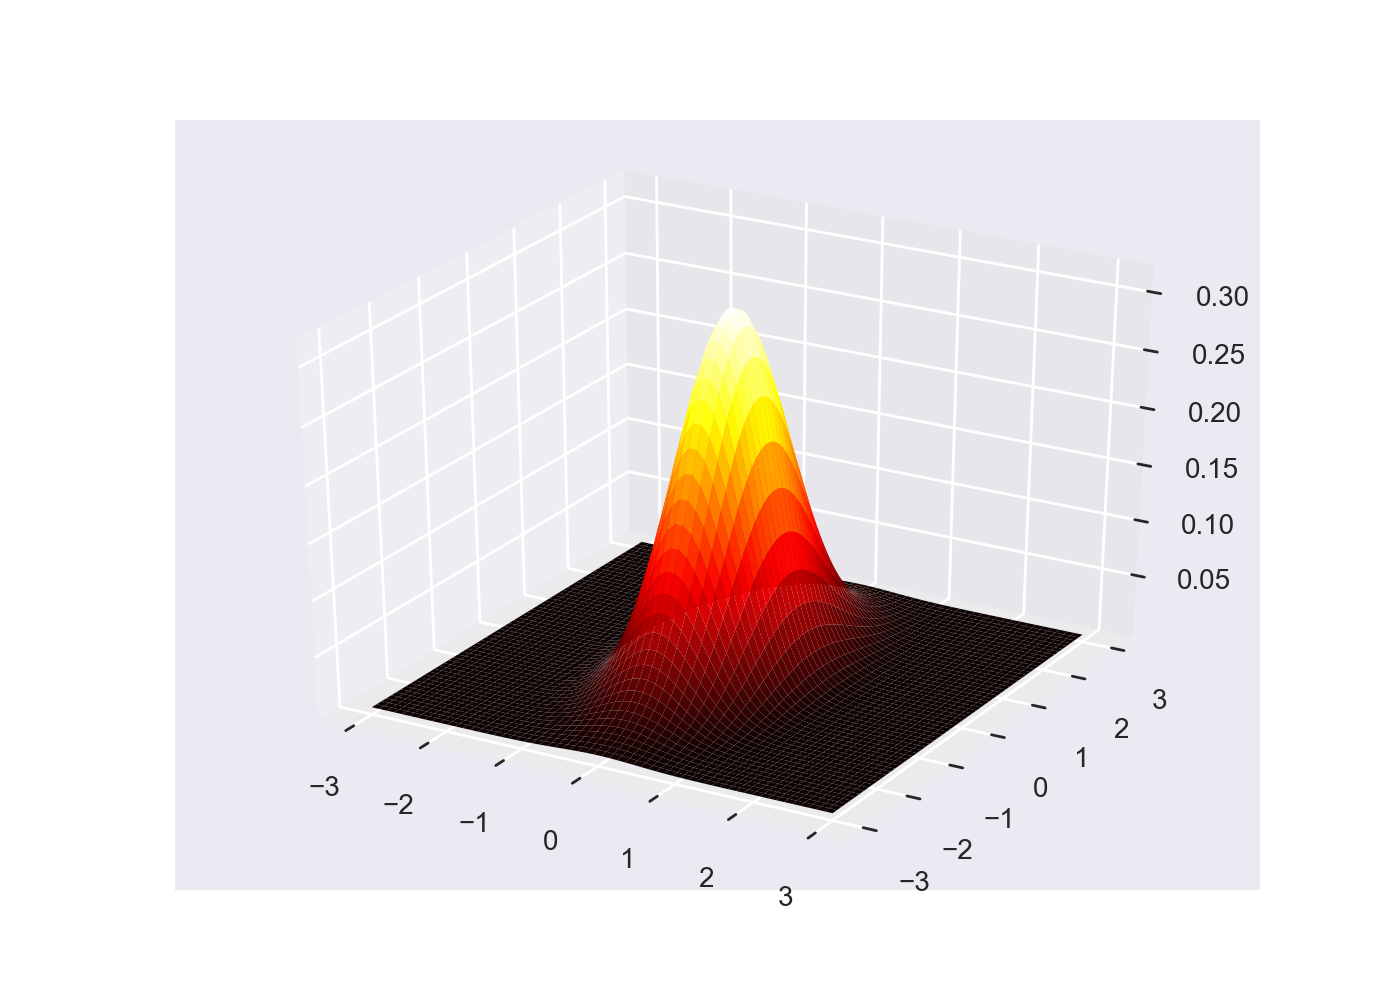

<class 'dict'>
{'rstride': 1, 'cstride': 1, 'cmap': 'hot', 'edgecolor': 'none', 'alpha': 0.99}


In [5]:
class PlotUtils(object):
    
    @staticmethod    
    def create_surface_data(xy_box, z_calc):
        

        x_min = xy_box['x_min']
        x_max = xy_box['x_max']
        y_min = xy_box['y_min']
        y_max = xy_box['y_max']
        
        x_cnt = (x_max-x_min)*10
        y_cnt = (y_max-y_min)*10
        
        #x, y = np.mgrid[x_min:x_max:30j, y_min:y_max:30j]
        
        xv = np.linspace(x_min, x_max, x_cnt)
        yv = np.linspace(y_min, y_max, y_cnt)
        x,y = np.meshgrid(xv,yv)
        
        xy = np.column_stack([x.flat, y.flat])
        z = z_calc(xy)
        z = z.reshape(x.shape)
        return (x, y, z)

    @staticmethod
    def surface(axis, x, y, z, **kwargs):
        print(type(kwargs))
        assert(x.shape[0] == y.shape[0])
        assert(x.shape[1] == y.shape[1])
        assert(x.shape[0] == z.shape[0])
        assert(x.shape[1] == z.shape[1])

        print(kwargs)
        return axis.plot_surface(x,y,z, **kwargs)
        

        
    
class PlotUtils_Test(object): 
    @staticmethod
    def test_all():
        PlotUtils_Test.test_surface()
        
    @staticmethod
    def test_surface():
        
        do_test = True # change to test for testing
        if not do_test:
            return
        
        mu = np.array([0.0, 0.0])

        sigma = np.array([.5, 1.0])
        covariance = np.diag(sigma**2)

        def mvn_pdf(xy):
            return mvn.pdf(xy, mean=mu, cov=covariance)

        #x,y,z = PlotUtils.create_surface_data(
        #            {'x_min': -3, 'x_max': 3, 'y_min': -3, 'y_max': 3},
        #            lambda xy: mvn.pdf(xy, mean=mu, cov=covariance)
        #        )    

        x,y,z = PlotUtils.create_surface_data(
            {'x_min': -3, 'x_max': 3, 'y_min': -3, 'y_max': 3},mvn_pdf
        )  
            
        (width, height) = (7,5)
        figsize = (width, height) if width and height else None
        fig = plt.figure(3, figsize=figsize)
        ax = fig.add_subplot(1,1,1, projection='3d')
        PlotUtils.surface(ax,x,y,z,rstride=1, cstride=1, 
                            cmap="hot",
                            edgecolor='none',alpha=0.99)   
        #ax.plot_surface(x,y,z, rstride=1, cstride=1, 
        #                    edgecolor='none',alpha=0.99, cmap="hot")
       
    
        plt.show()

        
PlotUtils_Test.test_all()  


<IPython.core.display.Javascript object>


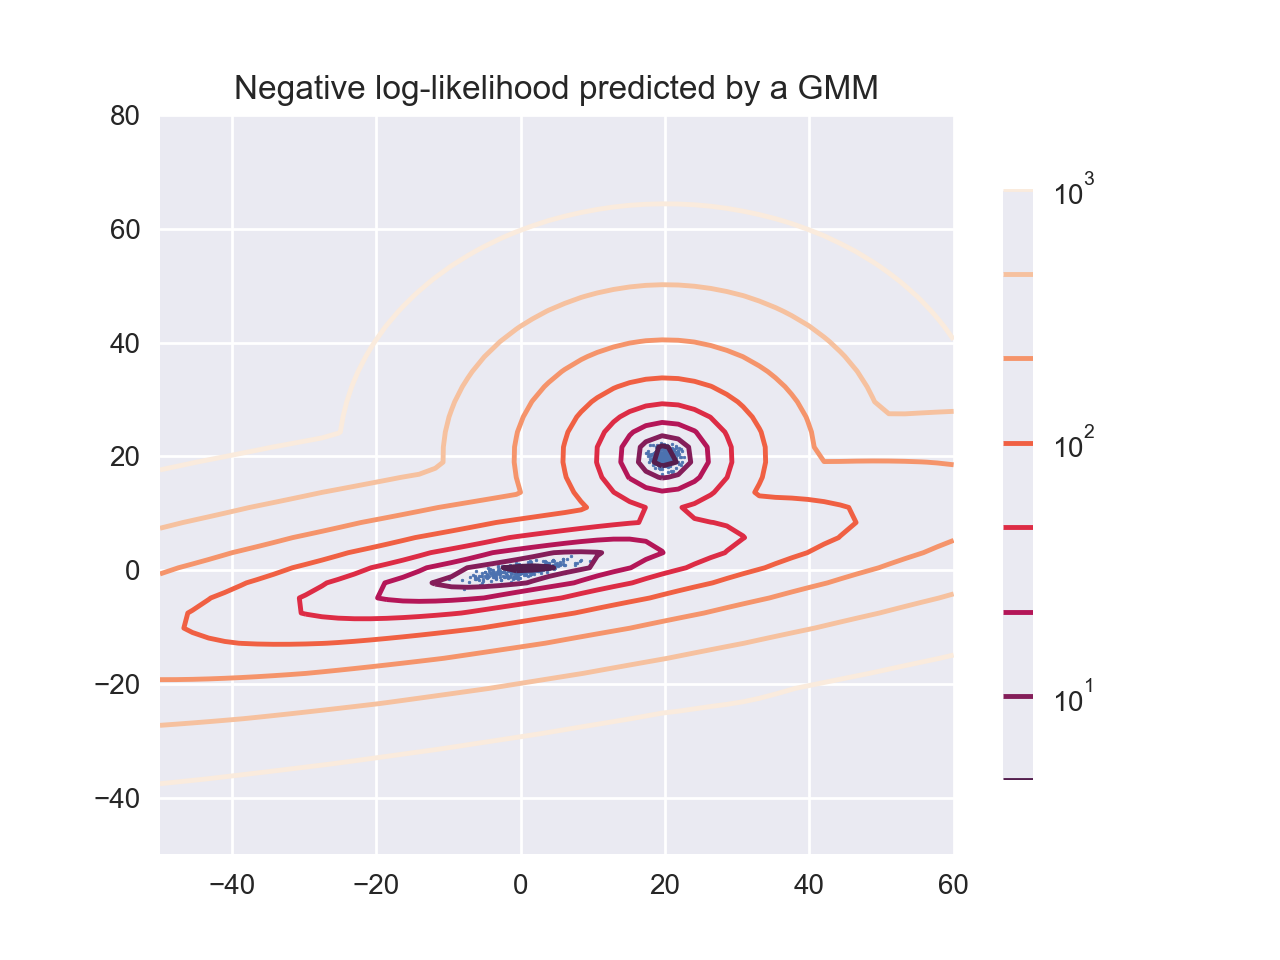

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
#x = np.linspace(-20., 30.)
#y = np.linspace(-20., 40.)
x = np.linspace(-50., 60.)
y = np.linspace(-50., 80.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)


plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()




### GMM with EM demo


<IPython.core.display.Javascript object>


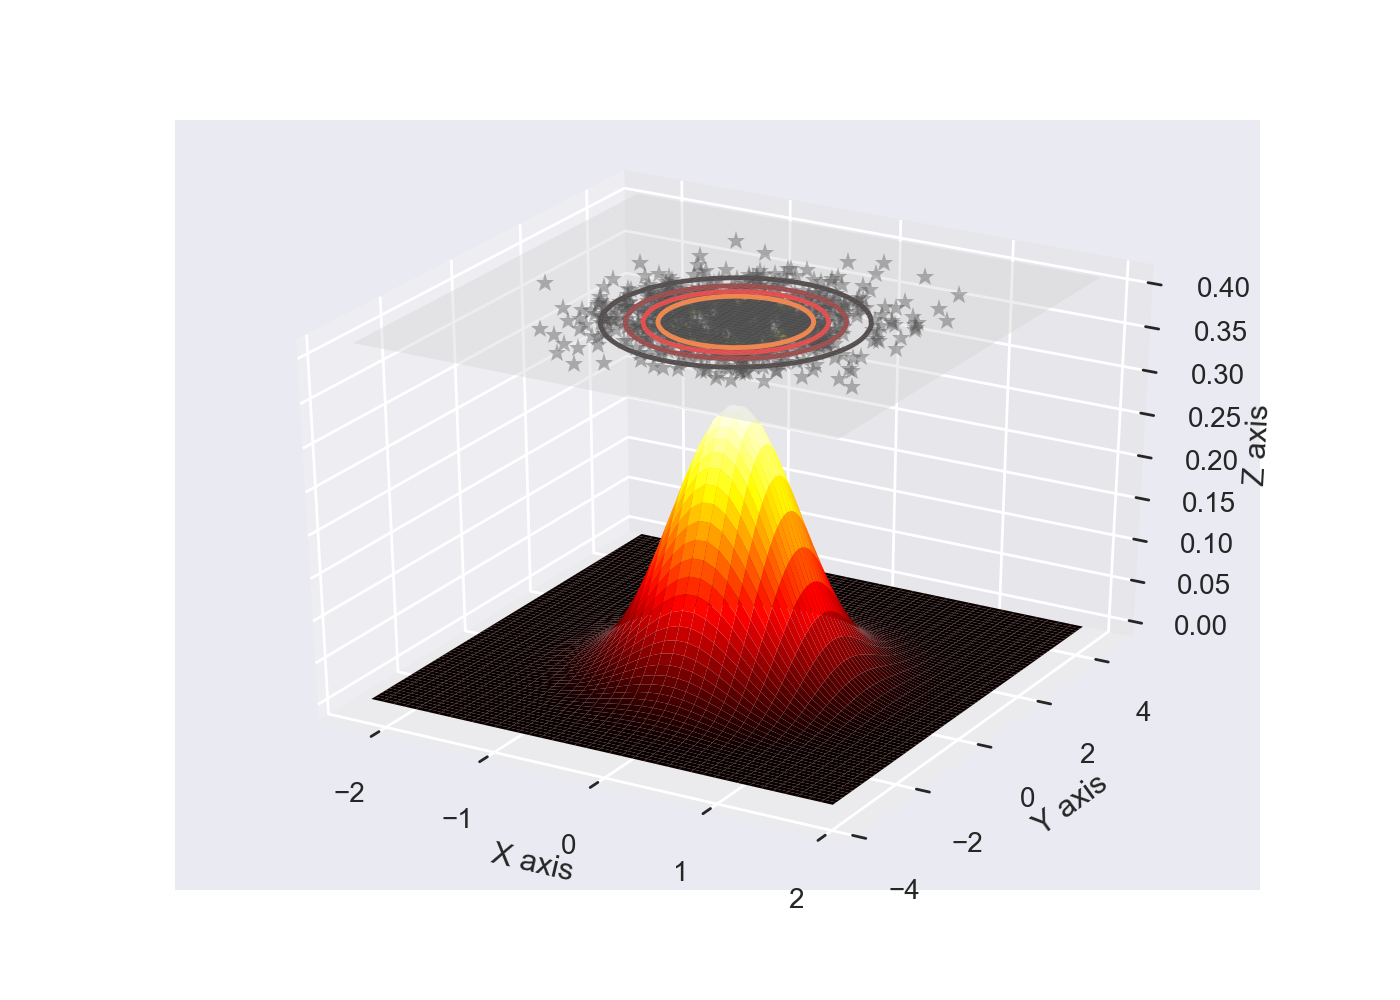

/Users/singhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/singhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


surf= <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x1c2136e6a0>
cset= <matplotlib.contour.QuadContourSet object at 0x1c211a7828>
data_scatter= [<mpl_toolkits.mplot3d.art3d.Line3D object at 0x1c21551f98>]
data_plane= <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x1c211ae208>


In [8]:
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class MVN(object):
    
    def __init__(self, mean, cov, generate=False):
        MVN._check_integrity( mean, cov)
        self.mean = mean
        self.cov = cov
        self.dim = len(self.mean)
        self.data = None
        
         
    def random(self, num_samples=1000):
        samples = MVN._random(self.mean, self.cov, num_samples)
        return samples
    
    def likelihood(self, samples):
        return MVN._likelihood(samples)
    
    def plot3d(self, data, z_lims=None, axes=None, xy_grid=None):
        return MVN._plot_3d(data, xy_grid, z_lims, axes, mu=self.mean, cov=self.cov)
        
    @staticmethod    
    def _random(mean, cov, num_samples=1000):
        samples = np.random.multivariate_normal(mean, cov, num_samples)
        return samples
    
    @staticmethod
    def _likelihood(samples, mean, cov):
        if samples.shape[1] != self.dim:
            print("ERROR dimension mismatched")
        
        prob = np.zeros(shape=len(samples))
        prob = mvn(mu, cov).pdf(samples)
        return prob
    
    @staticmethod
    def _plot_3d(data, xy_grid, z_lims =None, axes=None, mu=None, cov=None):
        
        if not axes or axes.name != "3d":
            (width, height) = (7,5)
            figsize = (width, height) if width and height else None
            fig = plt.figure(3, figsize=figsize)
            axes = fig.add_subplot(1,1,1, projection='3d')
        
        def is_null_ndarray(nda):
            if isinstance(nda, (np.ndarray, np.generic) ):
                return nda.size == 0
            elif nda == None:
                return True
            else:
                return False
           
        if is_null_ndarray(mu)  or is_null_ndarray(cov):
            print("No mu or sigma given assuming default.")
        
            mu = np.array([0.0, 0.0])

            sigma = np.array([.5, 1.0])
            
            covariance = np.diag(sigma**2)
            cov = covariance
        
        
        if is_null_ndarray(data):
            data=MVN._random(mu, cov)
        
        data_x_proj = data[:,0]
        data_y_proj = data[:,1]
        
        
        
        if not xy_grid:
            xy_grid = {}
            xy_grid['x_min'] = np.min(data_x_proj.ravel())*1.3
            xy_grid['x_max'] = np.max(data_x_proj.ravel())*1.3
            xy_grid['y_min'] = np.min(data_y_proj.ravel())*1.3
            xy_grid['y_max'] = np.max(data_y_proj.ravel())*1.3
            
           
        artists = []
        x,y,z = (None, None, None)
       
        
        def mvn_pdf(xy):
                return mvn.pdf(xy, mean=mu, cov=cov)

        #x,y,z = PlotUtils.create_surface_data(
        #            {'x_min': -3, 'x_max': 3, 'y_min': -3, 'y_max': 3},
        #            lambda xy: mvn.pdf(xy, mean=mu, cov=covariance)
        #        )    

        x,y,z = PlotUtils.create_surface_data(
                      xy_grid,
                      mvn_pdf
                  )  
            
      
        data_x_proj = data[:,0]
        data_y_proj = data[:,1]
        
        
        
        # plot theoritical guassian surface
        zlim_max = 0
        zlim_min = 0
        if not z_lims:
            zlim_min = np.min(z.ravel()) - 0.01
            zlim_max = np.max(z.ravel())*1.3
        else:
            zlim_min = z_lims['z_min']
            zlim_max = z_lims['z_max']
            
        zlim_min = np.min(z.ravel()) - 0.01
        zlim_max = np.max(z.ravel())*1.3
        plane_z = zlim_max
        surf = axes.plot_surface(x, y, z, rstride=1, cstride=1, cmap='hot',
                        edgecolor='none')

        print("surf=", surf)
        artists.append(surf)
        
        # plot 2d countour
        data_x_proj = data[:,0]
        data_y_proj = data[:,1]
        cset = axes.contour(x, y, z, zdir='z', offset=plane_z, cmap="hot")
        artists.append(cset)
        print("cset=", cset)
        
        # plot scatter point for data
        data_scatter = axes.plot(data_x_proj, data_y_proj,  'k*', alpha=0.4, zdir='z',
                zs=plane_z, zorder=3)

        for artist in data_scatter:
            artists.append(artist)
            
        print("data_scatter=", data_scatter)
        # plot plane containing scatter points for data
        plane_zz = np.zeros(shape=x.shape)
        plane_zz.fill(plane_z)
        data_plane = axes.plot_surface(x,y,plane_zz, rstride=1, cstride=1, 
                        cmap=colors.ListedColormap(['lightgray']),
                        edgecolor='none', alpha=0.4)

        artists.append(data_plane)
        print("data_plane=", data_plane)
        axes.set_zlim3d(zlim_min, zlim_max);

        #axes.set_xlim(0, 10)
        #axes.set_ylim(0, 10)
        #axes.set_zlim(0, 10)
        axes.set_xlabel('X axis')
        axes.set_ylabel('Y axis')
        axes.set_zlabel('Z axis')

        #plt.show()
        #return list of artists
        return artists
    

    
    @staticmethod
    def _check_integrity(mean, sigma):
        """
        Check that combination of mixing proportion, means and sigmas are consistent
        """
        
        # number of dimensions
        num_mean_dims = mean.shape[0]
        
        # numver of dimensions for point or vector 
        num_sigma_dims = sigma.shape
        
        # make sure number of entry in mean is same as dim of sigma
        assert(num_mean_dims == num_sigma_dims[0])
        assert(num_mean_dims == num_sigma_dims[1])
        
        return
    
   




if False:
    x, y = np.mgrid[-2.0:2.0:30j, -2.0:2.0:30j]
    print("x=", x.shape)
    print("y=", y.shape)
    #print(x)
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([x.flat, y.flat])

    mu = np.array([0.0, 0.0])

    sigma = np.array([.5, 1.0])
    covariance = np.diag(sigma**2)

    z = mvn.pdf(xy, mean=mu, cov=covariance)

    print("z=", z.shape)
    print("xy=", xy.shape)

    # Reshape back to a (30, 30) grid.
    z = z.reshape(x.shape)

    data=MVN._random(mu, covariance)
    print("data=", data.shape)

    fig = plt.figure(figsize=(10, 10))
    ax = add_subplot(1,1,1, projection='3d')
       
    MVN._plot_3d(x,y,z, ax)


fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1,1,1, projection='3d')    

mu = np.array([0.0, 0.0])
sigma = np.array([.5, 1.0])
covariance = np.diag(sigma**2)

my_mvn = MVN(mean=mu, cov=covariance)
data = my_mvn.random()
artists = my_mvn.plot3d(data, axes=ax)

#artists = MVN._plot_3d(data=None, axes=ax, xy_grid=None)
plt.show()

<IPython.core.display.Javascript object>


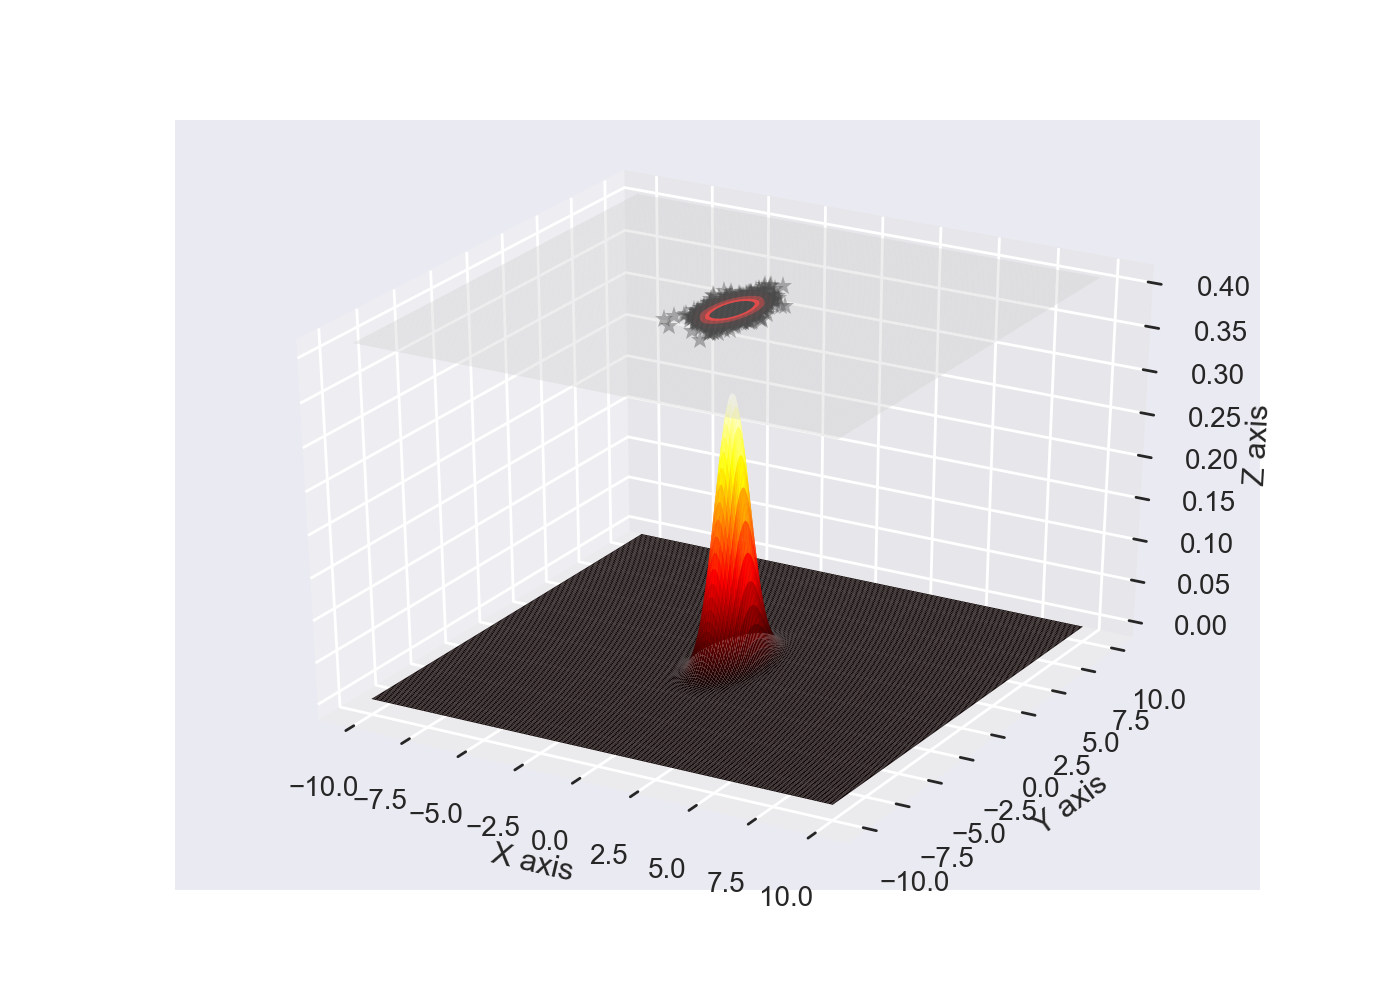

In [15]:
from matplotlib.animation import FuncAnimation

from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class MVN_Demo(object):
    def __init__(self, fig = None, axes = None):
        self.success = 0
        self.artists = []
        
        if not fig or not axes: 
            fig = plt.figure(figsize=(7, 5))
            axes = fig.add_subplot(1,1,1, projection='3d') 
            
        self.fig = fig
        self.axes = axes
        self.xy_grid = {'x_min': -10, 'x_max': 10, 'y_min': -10, 'y_max': 10}
        self.z_lims = {'z_min':-0.1, 'z_max':0.4}
        #plt.show()
        
        # Set up plot parameters
        #self.ax.set_xlim(0, 1)
        #self.ax.set_ylim(0, 15)
       
        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        
    def plot(self, i):
        print("i=", i)
        print("ax=", self.axes)
        #self.fig.clear()
        
        mu_step = 1
        mu = np.array([0.0+i*mu_step, 0.0+i*mu_step])
        #print(mu)
        sigma = np.array([.5, 1.0])
        covariance = np.diag(sigma**2)

        my_mvn = MVN(mean=mu, cov=covariance)
        data = my_mvn.random()
        self.axes.clear()
        artists = my_mvn.plot3d(data, axes=self.axes, xy_grid=self.xy_grid, z_lims=self.z_lims)
        self.artists = artists
        #plt.draw()
        return artists
        
    def init(self):
        obj = self.plot(0)
        return obj,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()

        # Choose success based on exceed a threshold with a uniform pick
        obj = self.plot(i)
        return obj,


fig = plt.figure(figsize=(7, 5))
xy_grid = {'x_min': -10, 'x_max': 10, 'y_min': -10, 'y_max': 10}
z_lims = {'z_min':-0.1, 'z_max':0.4}
axes = fig.add_subplot(1,1,1, projection='3d') 
    
mvn_demo = MVN_Demo(fig=fig, axes=axes, )

#mvn_demo.plot(100)
if  True:
    anim = FuncAnimation(mvn_demo.fig, mvn_demo, frames=np.arange(10), init_func=mvn_demo.init,
                        interval=100, blit=False)

    plt.show()
    #fig = None
    #axes = None

import matplotlib.animation as animation

if False:

    frames_of_artists = []
    for i in range(10):
        ith_frame_of_artists = mvn_demo.plot(i)
        frames_of_artists.append(ith_frame_of_artists)

    #print(frames_of_artists)     
    anim = animation.ArtistAnimation(fig, frames_of_artists, interval=1000, blit=False,
                                repeat_delay=1, repeat = True)
    
    plt.show()
    fig = None
    axes = None
    
if False:
    fig = plt.figure(figsize=(7, 5))
    xy_grid = {'x_min': -10, 'x_max': 10, 'y_min': -10, 'y_max': 10}
    axes = fig.add_subplot(1,1,1, projection='3d') 
        #plt
        
    i = 2
    mu = np.array([0.0+i*0.1, 0.0+i*0.1])
    print(mu)
    sigma = np.array([.5, 1.0])
    covariance = np.diag(sigma**2)

    my_mvn = MVN(mean=mu, cov=covariance)
    data = my_mvn.random()
    artists = my_mvn.plot3d(data, axes=axes, xy_grid=xy_grid)
    

In [17]:
   
class GMM(object):
    
    def __init__(self, means, sigmas, mixings, data=None):
        
        GMM._check_integrity(mixings, means, sigmas)
        self.means = means
        self.sigmas = sigmas
        self.mixings = mixings
        
        if not isinstance(data, np.ndarray):
            data = GMM.generate(self.mixings, self.means, self.sigmas, num_samples = 1000)
        
        self.data = data
        
        
    @staticmethod    
    def generate(mixings, means, sigmas, num_samples=1000):
        samples = np.concatenate([np.random.multivariate_normal(mean, sigma, int(mixing*num_samples))
                    for mixing, mean, sigma in zip(mixings, means, sigmas)])
        return samples
    
    @staticmethod
    def freq2prob(freq):
        prob = np.copy(freq)
        prob /= prob.sum()
        
    @staticmethod
    def prob(samples, mixings, means, sigmas):
        GMM._check_integrity(mixings, means, sigmas)
        prob = np.zeros(shape=len(samples))
        for pi, mu, sigma in zip(mixings, means, sigmas):
            #print("mu=",mu)
            #print("sigma=",sigma)
            #print("pi=",pi)
            prob += pi*mvn(mu, sigma).pdf(samples)
            
        return prob    
            
    @staticmethod
    def _check_integrity(mixings, means, sigmas):
        """
        Check that combination of mixing proportion, means and sigmas are consistent
        """
        # number of mixing components.
        num_mixings = mixings.shape[0]
        
        # number of mean vectors or points. Each point corresponds to one guassian distribution
        num_means_dims = means.shape[0]
        
        # numver of dimensions for point or vector 
        num_means = means.shape[1]
        
        assert(num_mixings == num_means)
        return
    

In [18]:

class GMM_EM(object):
    
    def __init__(self, gmm):
        self.gmm = gmm
        self.expectation = {}
        self.expectation['A'] = []
        self.expectation['B'] = []
        self.log_liklihood = 0
        self.sample_weights = np.zeros((1,1))
        self.num_samples = -1
        self.num_dims = -1
        self.em_step = {}
        self.em_final_pred = {}
        self.inp = {}
        self.em_init()
    
    
    def em_init(self, ):
        gmm = self.gmm
       
        self.em_step['count'] = 0
        self.em_step['k'] = len(gmm.mixings)
        self.em_step['n'] = gmm.data.shape[0]
        self.em_step['d'] = gmm.data.shape[1]
        self.em_step['sample_weights'] = 0
        self.em_step['mixings'] = GMM.freq2prob(np.random.random(self.em_step['k']))
        self.em_step['means'] = np.random.random((self.em_step['k'], self.em_step['k']))
        self.em_step['sigmas'] = np.array([np.eye(self.em_step['k'])] * 2)
        self.em_step['likelihood'] = 0.0
        self.em_step['prev_likelhood'] = 0.0
        self.inp['xs'] = None
 
    
    def e_step(self, ):
        gmm = self.gmm
        
        k = self.em_step['k']
        n = self.em_step['n']
        means = self.em_step['means'] 
        sigmas = self.em_step['sigmas']
        mixings = self.em_step['mixings']
        data = gmm.data
        # E-step
        ws = np.zeros((k, n))
        pis = gmm.mixings
        for j in range(len(means)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(means[j], sigmas[j]).pdf(data[i])
        ws /= ws.sum(0)
        
        self.em_step['sample_weights'] = ws
        
    def m_step(self, ):
        gmm = self.gmm
        data = gmm.data
        k = self.em_step['k']
        n = self.em_step['n']
        p = self.em_step['d']
        ws = self.em_step['sample_weights']
        
        
        pis = np.zeros(k)
        for j in range(p):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n
        
        self.em_step['mixings'] = pis

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * data[i]
            mus[j] /= ws[j, :].sum()

        self.em_step['means'] = mus
        
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        self.em_step['sigmas'] = sigmas
        
    def update_likelihood(self):
        
        pis = self.em_step['mixings']
        mus = self.em_step['means']
        sigmas = self.em_step['sigmas']
        k = self.em_step['k']
        n = self.em_step['n']
        p = self.em_step['d']
        data = self.gmm.data
        ll_old = self.em_step['likelihood']
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(data[i])
            ll_new += np.log(s)

       
        self.em_step['likelihood'] = ll_new
        self.em_step['prev_likelhood'] = ll_old
        
        return 
    def em_1step(self):
        #self.em_step['likelihood'] = 0.0
        self.e_step()
        self.m_step()
        self.update_likelihood()
        return (self.em_step['likelihood'], self.em_step['mixings'], self.em_step['means'], self.em_step['sigmas'] )
            
    def em(self, xs, max_iter=300, tol = 0.01):
        
        self.inp["xs"] = xs
        #self.em_step['prev_likelhood'] = 0.0
        for i in range(max_iter):
            self.em_1step()
            if np.abs(self.em_step['likelihood'] -  self.em_step['prev_likelhood']) < tol:
                break
            
        self.em_final_pred['likelihood'] = self.em_step['likelihood']
        self.em_final_pred['mixings'] = self.em_step['mixings']
        self.em_final_pred['means'] = self.em_step['means']
        self.em_final_pred['sigmas'] = self.em_step['sigmas']
        return (self.em_step['likelihood'], self.em_step['mixings'], self.em_step['means'], self.em_step['sigmas'])   
    



In [19]:

np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])
np.random.seed(123)
gmm = GMM(_mus, _sigmas, _pis)
gmm_em = GMM_EM(gmm)


ll1, pis1, mus1, sigmas1 = gmm_em.em(xs)

print(ll1, pis1, mus1, sigmas1)


# initial guesses for parameters
#pis = np.random.random(2)
#pis /= pis.sum()
#mus = np.random.random((2,2))
#sigmas = np.array([np.eye(2)] * 2)




-3690.55262905 [ 0.59367007  0.40632993] [[-0.02977086  3.98049867]
 [-1.94726357  0.01699411]] [[[ 3.02736994  0.01341653]
  [ 0.01341653  0.48310159]]

 [[ 0.90086008  0.04752486]
  [ 0.04752486  2.03579722]]]


<IPython.core.display.Javascript object>


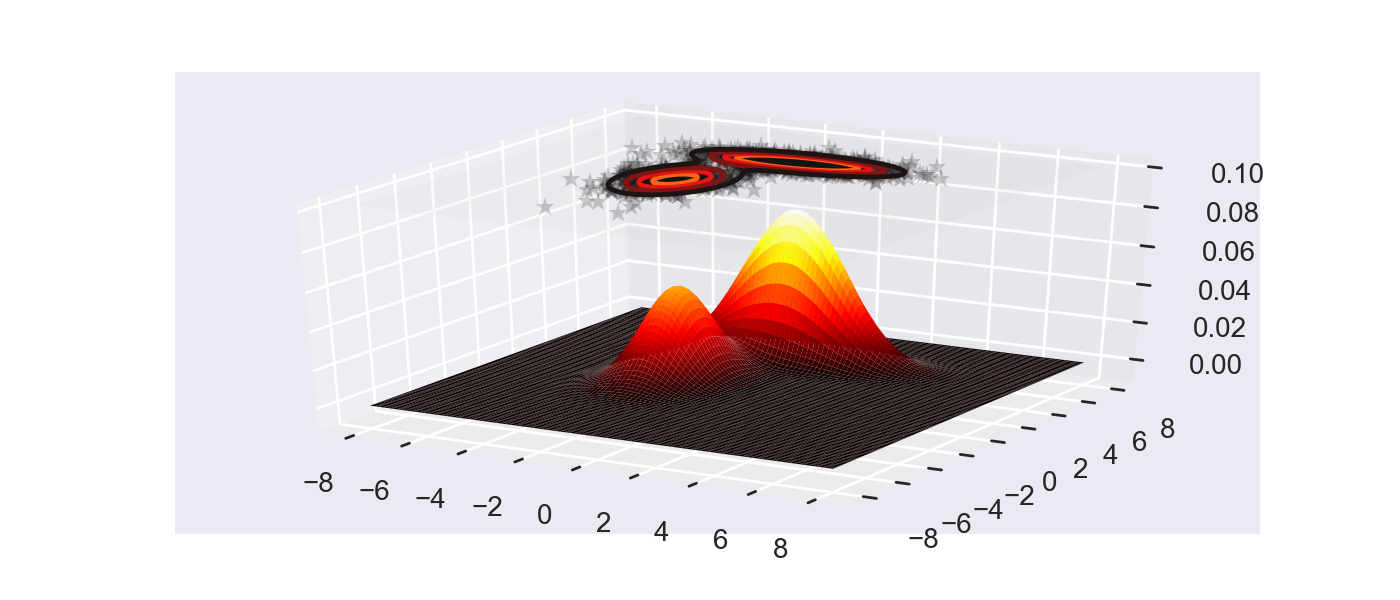

In [20]:
xs = gmm.data
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T
#print(X.shape, mus1.shape, )
#print(_ys.shape)
#print("mu1=",mus1.shape)
#print("sigma1=",sigmas1.shape)
#print("pi1=",pis1.shape)


z=GMM.prob(_ys, pis1, mus1, sigmas1)

z = z.reshape((intervals, intervals))
#print(z)
#print(z.shape)

def plot2d_gmm(x, y, z, data):
    width=10
    height=5
    figsize = (width, height) if width and height else None
    fig = plt.figure(1, figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    data_x_proj = data[:,0]
    data_y_proj = data[:,1]
    ax1.scatter(data_x_proj, data_y_proj, alpha=0.2)
    ax1.contour(x, y, z, N=100)
    ax1.axis([-8,6,-6,8])

    ax2 = fig.add_subplot(1,2, 2, projection='3d')
    ax2.plot_surface(x,y,z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    plt.axis('equal')
    plt.show()


def plot3d_gmm(x, y, z, data, width = None, height=None):
    width = width or 7
    height = height or 3
    fig = plt.figure(figsize=(width, height))

    ax = fig.add_subplot(1,1,1, projection='3d')

    zlim_min = np.min(z.ravel()) - 0.01
    zlim_max = np.max(z.ravel())*1.3
    plane_z = zlim_max
    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='hot',)

    data_x_proj = data[:,0]
    data_y_proj = data[:,1]
    cset = ax.contour(x, y, z, zdir='z', offset=plane_z, cmap="hot")
    ax.plot(data_x_proj, data_y_proj,  'k*', alpha=0.2, zdir='z', zs=plane_z)

    plane_zz = np.zeros(shape=X.shape)
    plane_zz.fill(plane_z)
    ax.plot_surface(x,y,plane_zz, rstride=1, cstride=1, cmap=colors.ListedColormap(['lightgray']),
                 edgecolor='none', alpha=0.1)

    ax.set_zlim3d(zlim_min, zlim_max);

    plt.show()
    
#plot2d_gmm(X, Y, z, xs)    
plot3d_gmm(X, Y, z, xs)    

<IPython.core.display.Javascript object>


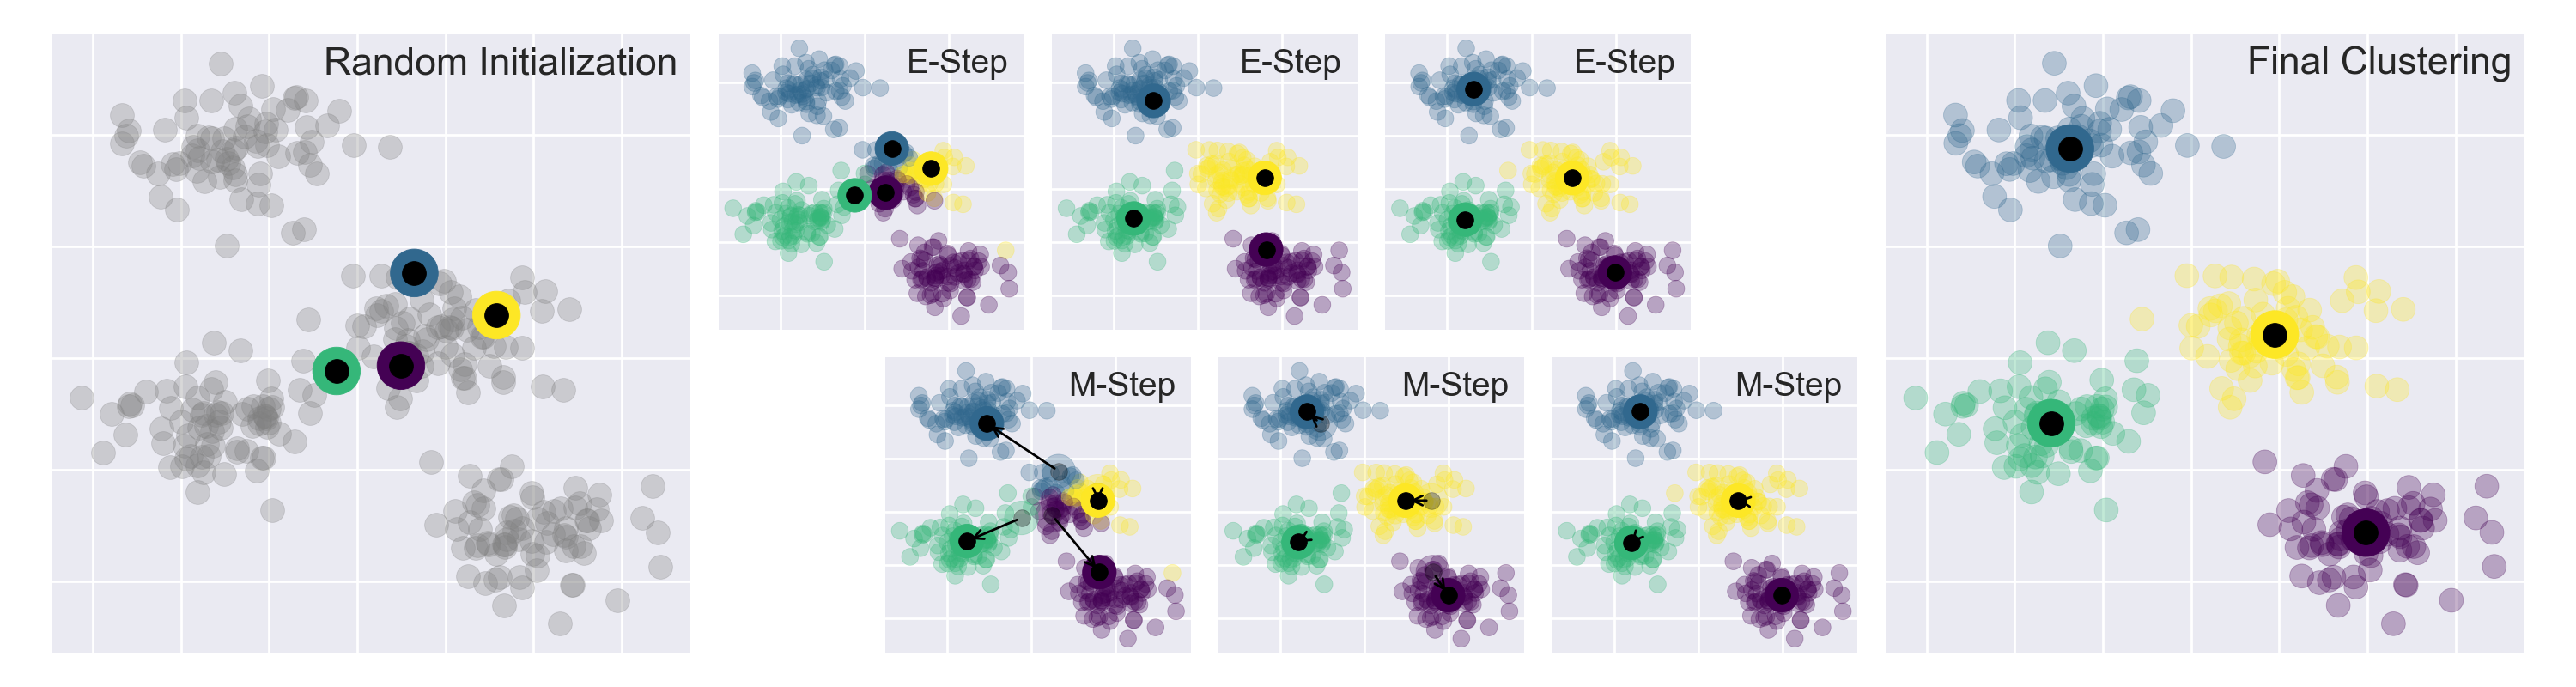

In [23]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

plt.show()


###### GMM time series


In [ ]:
#file:///Users/singhal/Downloads/Publication204.pdf
# http://www.povinelli.net/publications/papers/ieeetsp2006.pdf
    

###### Kmeans Simple Example

<IPython.core.display.Javascript object>


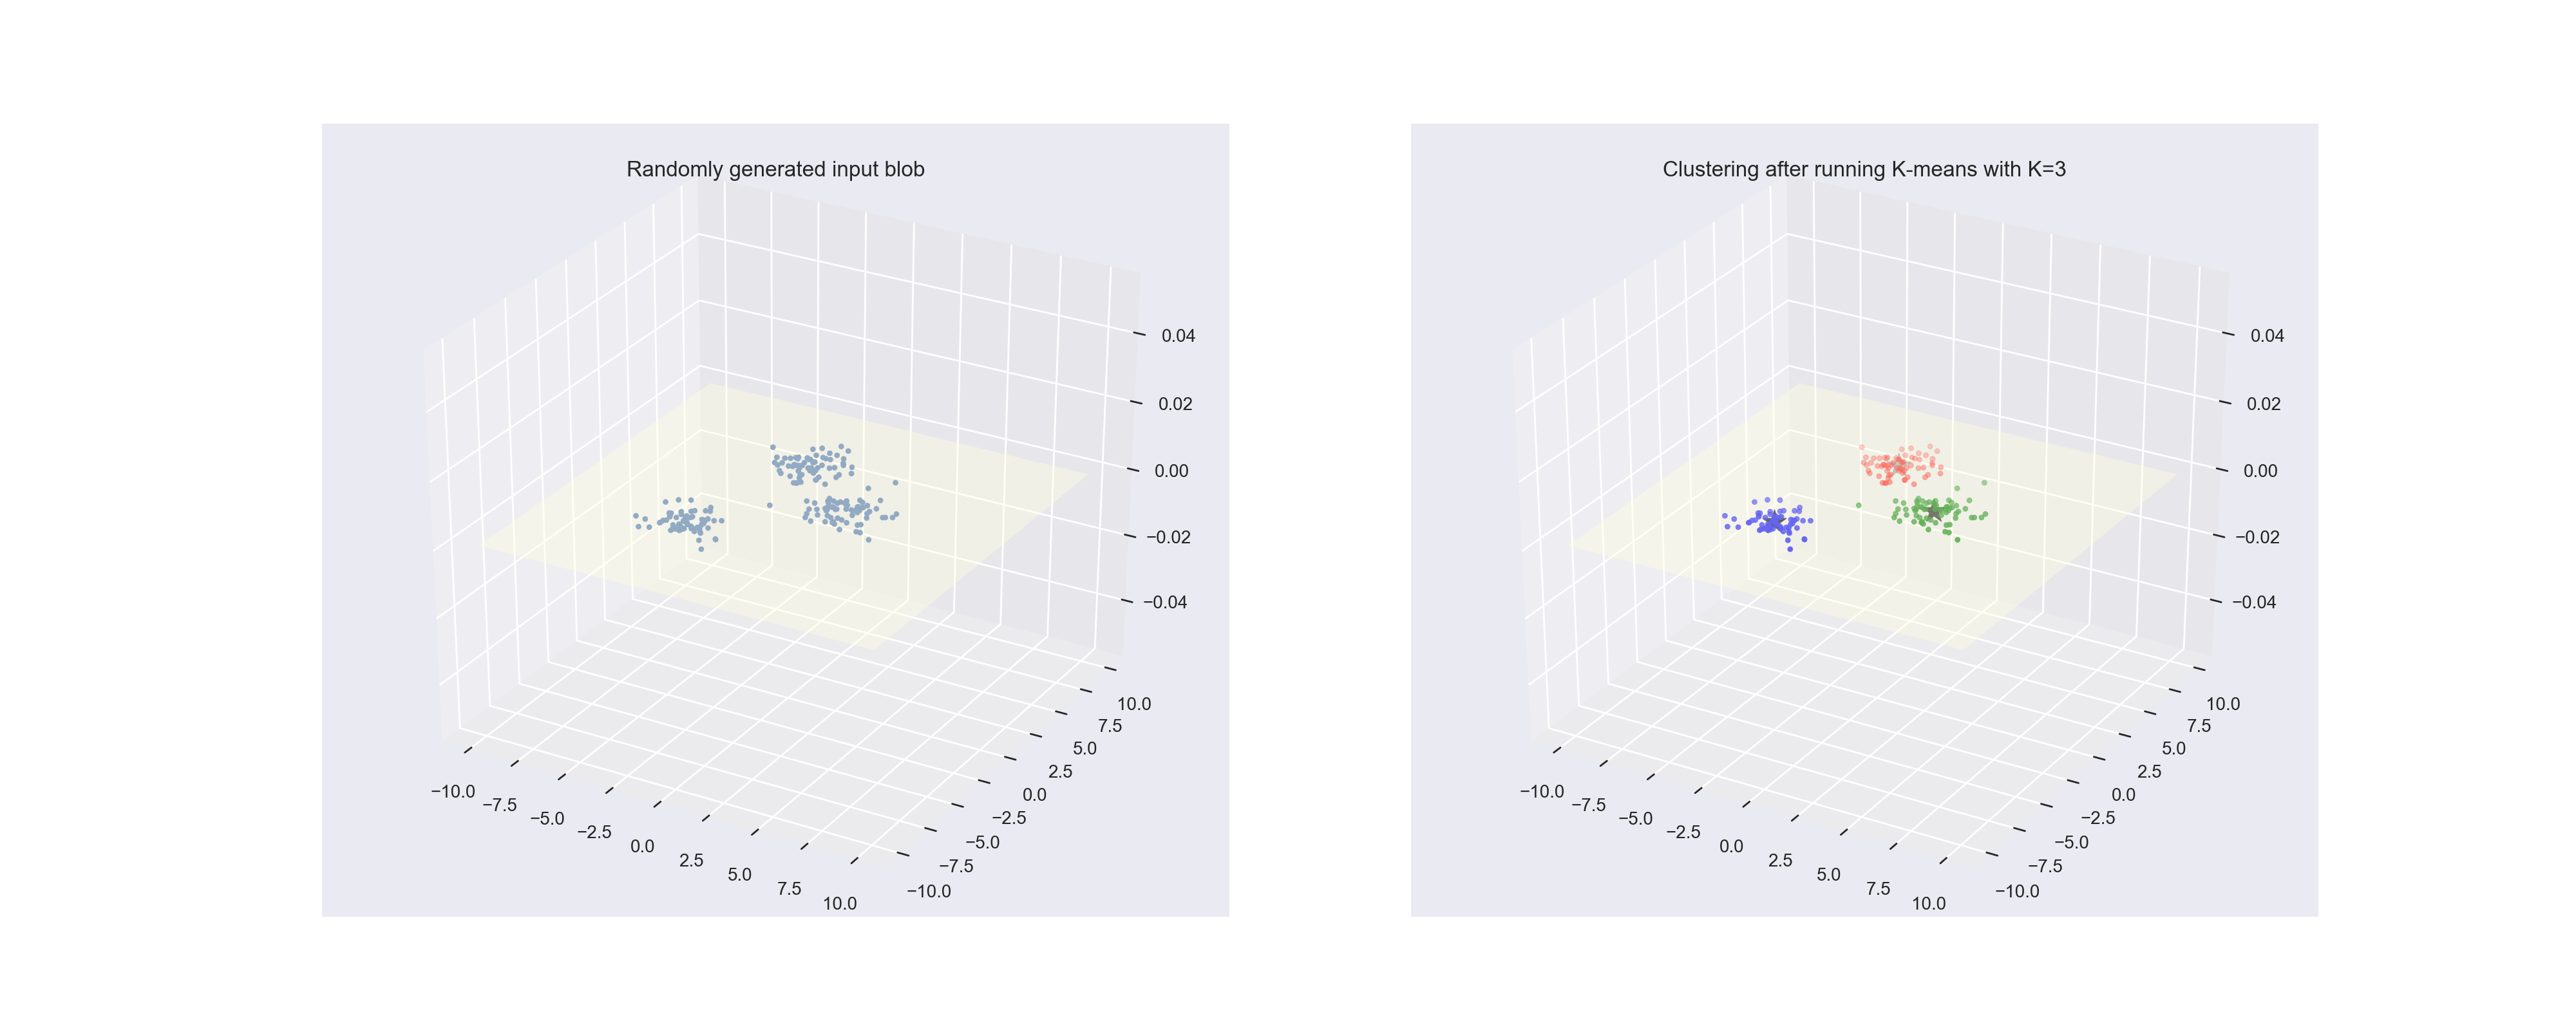

x,y,z (200,) (200,) (200,)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy import stats as sp_stats
from matplotlib import colors


width=20
height=8
fig = plt.figure(figsize=(width, height))

# Creating a sample dataset with 3 clusters
X, z = make_blobs(n_samples=200, n_features=2, centers=3, random_state=42, center_box=(-5,5))

x, y = (X[:, 0], X[:, 1])
print("x,y,z", x.shape, y.shape, z.shape)

#print(X)
kde = sp_stats.gaussian_kde(X.T)
xx, yy = np.mgrid[-10:10:30j, -10:10:30j]
density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)
zz = np.zeros(shape=xx.shape)
#print(density)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

#ax.plot_surface(xx)
#ax1.scatter(x, y, cmap=colors.ListedColormap(['black']), alpha=1)
#ax1.contour(xx, yy, density, zdir='z', cmap="hot")
#ax1.plot_surface(xx,yy,density, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.5)
ax1.plot_surface(xx,yy,zz, rstride=1, cstride=1, cmap=colors.ListedColormap(['lightyellow']),
                 edgecolor='none', alpha=0.4)
ax1.scatter(x, y, cmap=colors.ListedColormap(['black']), alpha=1, s=8)
ax1.set_title("Randomly generated input blob")

# Initializing KMeans
kmeans = KMeans(n_clusters=3)
# Fitting with inputs
kmeans = kmeans.fit(X)
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx,yy,zz, rstride=1, cstride=1, cmap=colors.ListedColormap(['lightyellow']),
                 edgecolor='none', alpha=0.4)

ax2.scatter(x, y,  c=z, cmap=colors.ListedColormap(['red', 'green', 'blue']), s=8)
ax2.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=200)
ax2.set_title("Clustering after running K-means with K=3")
plt.show()

##### KMeans for Unsupervised Classification

Accuracy of KMeans based classification =  0.790762381747


<IPython.core.display.Javascript object>


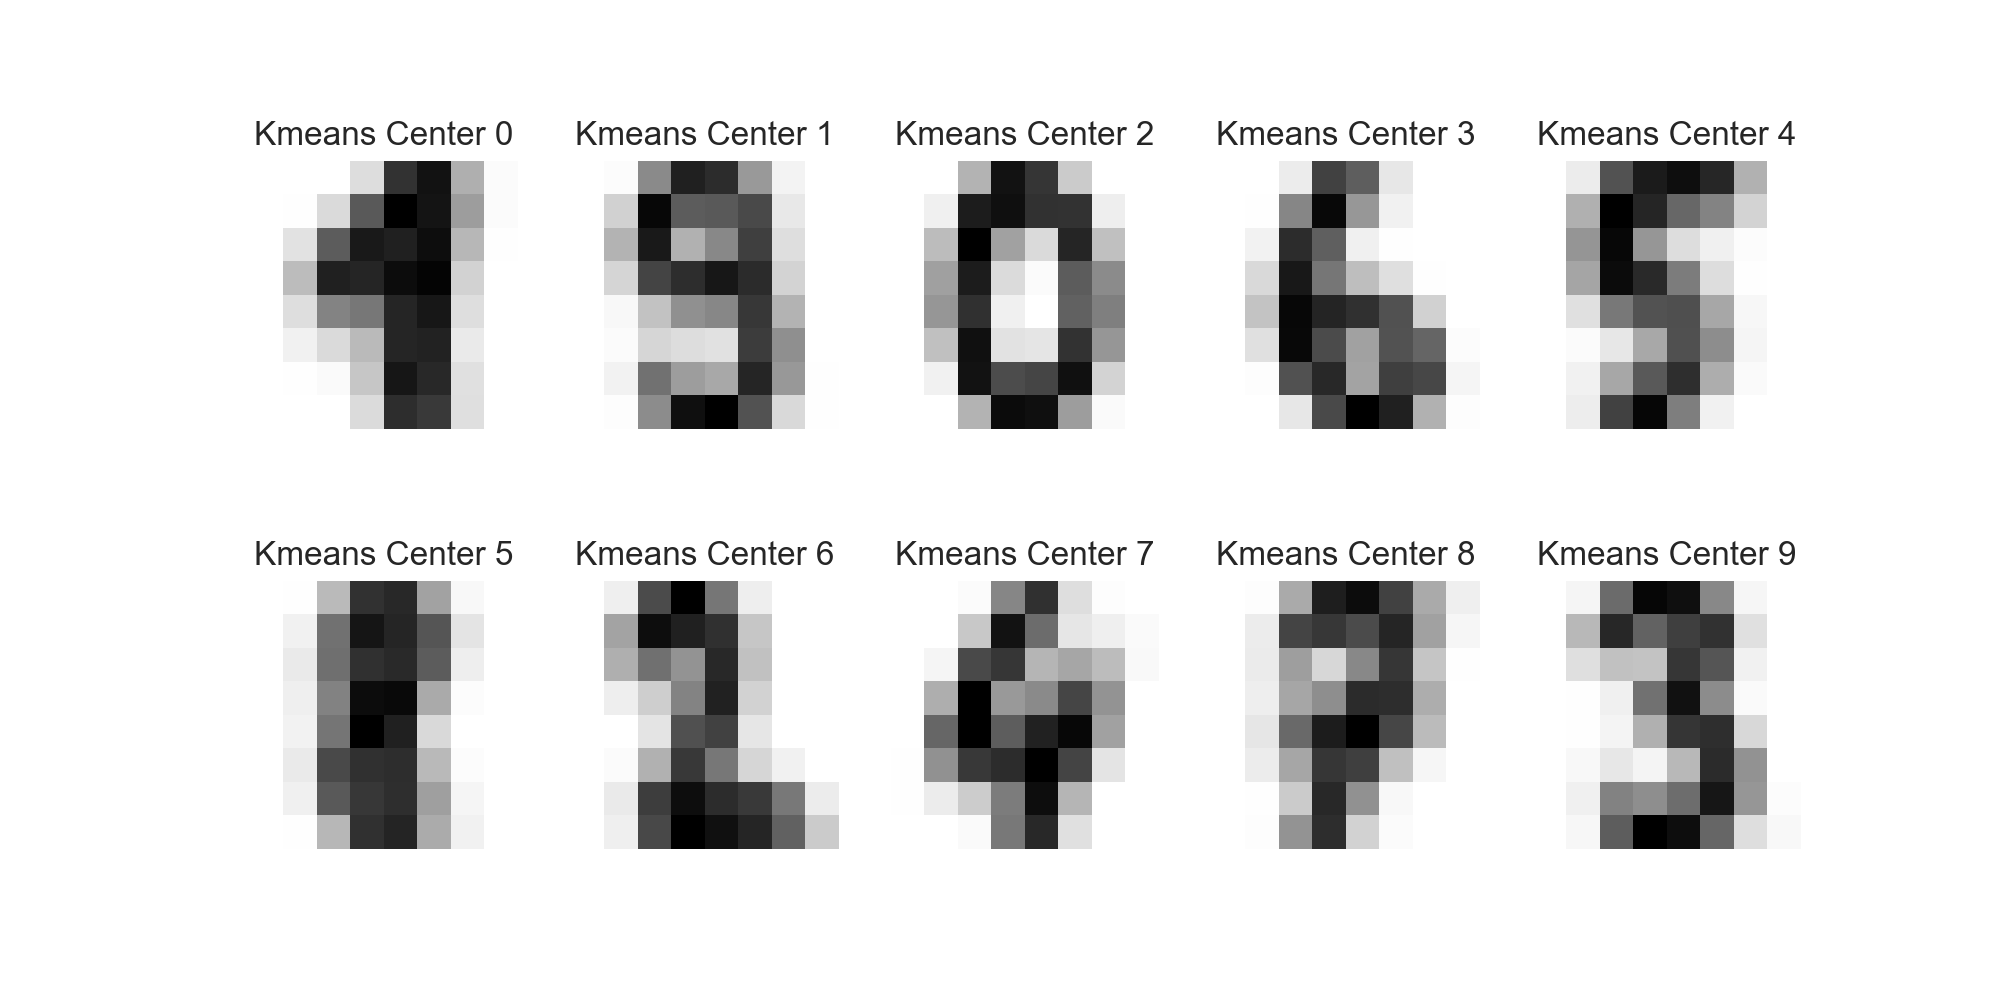

In [26]:
from scipy.stats import mode

def kmeans_classification(data, K=10):
    estimator = KMeans(n_clusters=K)
    estimator.fit(digits.data)
    digit_clusters = estimator.predict(digits.data)
    return dict(kmeans=estimator, clusters=digit_clusters)

def map2labels(pred_cluster_ids, actual_labels):
    """
    Since kmean can assign the cluster randomly i.e cluster called 5 may 
    belongs to digit label 3.Hence we have this util to convert it to the 
    labels of target digits.We use the idea that kmean cluster must have done
    a good enough job to combine similar digit in a cluster and hence mode 
    (i.e maximum occuring elements) is actually can be the real label of cluster
    """
    # find the unique clusters
    unq_clusters = np.unique(actual_labels).tolist()
    num_clusters = len(unq_clusters)
    
    # this is new labels
    labels = [0]*len(pred_cluster_ids)
    # map from predicted cluster label to actual label
    pcid2al = {}
    for cid in range(num_clusters):
        locs = [] # this will store the row id of the data
        sp_cid = 0
        for idx, p_cid in enumerate(pred_cluster_ids):
            if p_cid == cid:
                locs.append(idx)
                sp_cid = p_cid
         
        # find the histogram of actual label corresponding to the locations
        # of interest
        hist = [0]*num_clusters
        for loc in locs:
            actual_label = actual_labels[loc]
            hist[actual_label] =  hist[actual_label]+1
        # since kmean will do reasonable job, lets find maximum occuring label    
        max_occuring_label = hist.index(max(hist))  
        pcid2al[cid] = max_occuring_label
        #print("cid, maxlabel=",cid,sp_cid, max_occuring_label )
        # assign it to all the available location
        for loc in locs:
            labels[loc] =  max_occuring_label
            
    return dict(cid2labels=pcid2al, labels=np.array(labels))        

def eval_classification(target_real_labels, target_pred_labels):  
    accuracy=accuracy_score(target_real_labels, target_pred_labels)
    print("Accuracy of KMeans based classification = ", accuracy)
    
digits = datasets.load_digits()
kmeans_cls_infos = kmeans_classification(digits.data)
kmeans_est = kmeans_cls_infos['kmeans']
digits_clusters_labels = kmeans_cls_infos['clusters']


target_real_labels = digits.target
target_pred_labels_info = map2labels(digits_clusters_labels, target_real_labels)
target_pred_labels = target_pred_labels_info['labels']
center_pred_labels = target_pred_labels_info['cid2labels']
eval_classification(target_real_labels, target_pred_labels)

# get the image of the centers
centers = kmeans_est.cluster_centers_.reshape(10, 8, 8)

image_infos = []
for cid, center in enumerate(centers):
    image_info = {
                'image':center,
                'title': 'Kmeans Center %d' %(cid)
            }
    image_infos.append(image_info)
        
        
axarr = ImageUtils.plot(cmap=plt.cm.binary, ncols=5, width=10, height=5, 
                        image_infos=image_infos)



In [27]:
def kpca_reduction(data):
    
    kpca = KernelPCA(kernel="rbf", gamma=15, random_state=42, fit_inverse_transform=True, n_components=50)
    
    kcomp = kpca.fit_transform(data)

    kfilter = kpca.inverse_transform(kcomp)
    return kcomp

def pca_reduction(data):
    
    pca = PCA( n_components=30)
    
    data_txf = pca.fit_transform(data)

    return data_txf


digits = datasets.load_digits()
digits_pca = pca_reduction(digits.data)
kmeans_cls_infos = kmeans_classification(digits_pca)
digits_clusters = kmeans_cls_infos['clusters']

target_real_labels = digits.target
target_pred_labels_info = map2labels(digits_clusters, target_real_labels)
target_pred_labels = target_pred_labels_info['labels']
center_pred_labels = target_pred_labels_info['cid2labels']


eval_classification(target_real_labels, target_pred_labels)





Accuracy of KMeans based classification =  0.789092932666


###### KMeans Compression i.e Color Quantization 

<IPython.core.display.Javascript object>


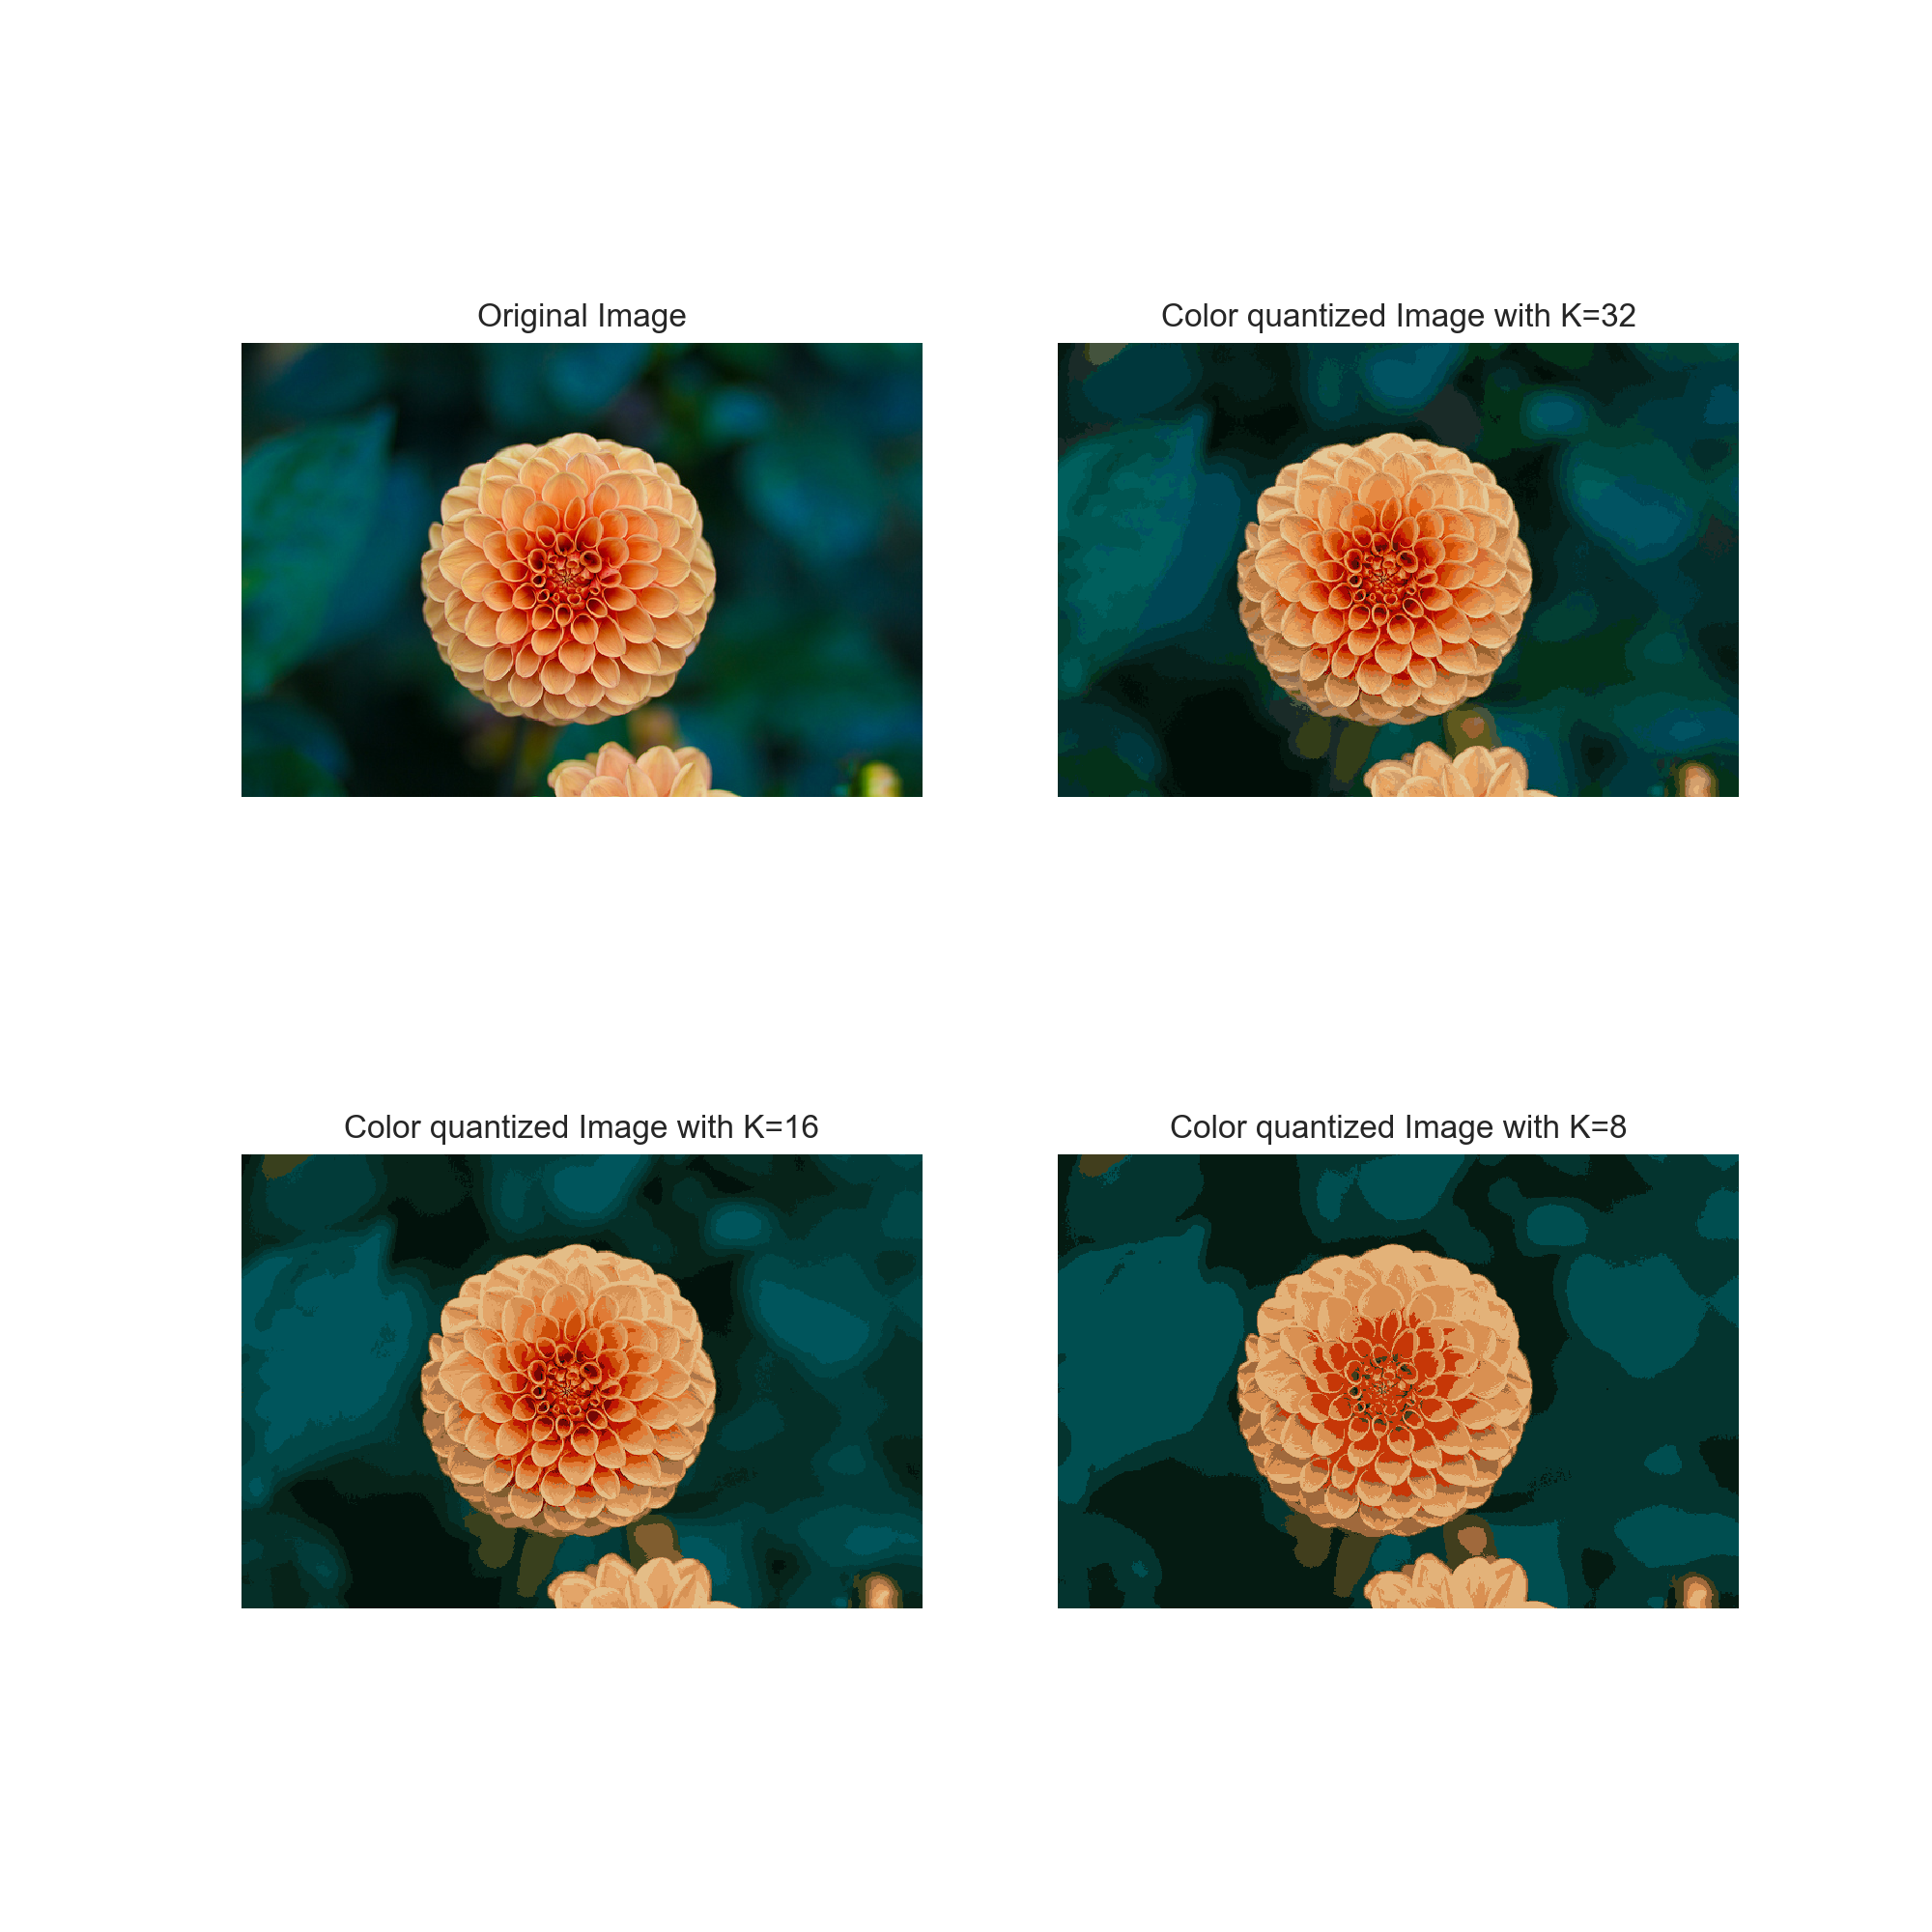

In [28]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time



def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


def kmeans_colors_quantization(im, K = 10):
    
    (w, h, d) = im_dims = ImageUtils.dimensions(im)
    im_2d = ImageUtils.image_to_npimage(im, im_dims) 

    t0 = time()
    # Since we would like to run our algorithm faster 
    im_2d_sample = shuffle(im_2d, random_state=0)[:1000]
    estimator = KMeans(n_clusters=K, random_state=0).fit(im_2d_sample)
    t1 = time()
    im_labels = estimator.predict(im_2d)
    t2 = time()
    im_centers = estimator.cluster_centers_
    im_quant = recreate_image(im_centers, im_labels, w, h)
    return dict(image=im_quant, kmeans=estimator, labels=im_labels)
    
    
def demo_kmeans_colors_quantization(im_org):
    im_norm = ImageUtils.normalize(im_org)
    
    image_infos = [
        {'image':im_norm, 'title':'Original Image'},
    ]
    n_colors = [32, 16, 8]
    for n_color in n_colors:
        kmean_quant = kmeans_colors_quantization(im_norm, K=n_color)
        im_compress = kmean_quant['image']
        im_labels = kmean_quant['labels']
        
        (w, h, d) = im_dims = ImageUtils.dimensions(im_org)
        image_info = {
            'image':im_compress,
            'title': 'Color quantized Image with K=%d' %(n_color)
        }
        image_infos.append(image_info)
        
    #cmap=plt.cm.gray
    axarr = ImageUtils.plot(cmap=None, ncols=2, width=10, height=10, 
                        image_infos=image_infos)


im_flower = load_sample_image("flower.jpg")

for im_org in (im_flower, ):    
    demo_kmeans_colors_quantization(im_org)
    
    

##### Kernel Kmean



###### Segmentation

<IPython.core.display.Javascript object>


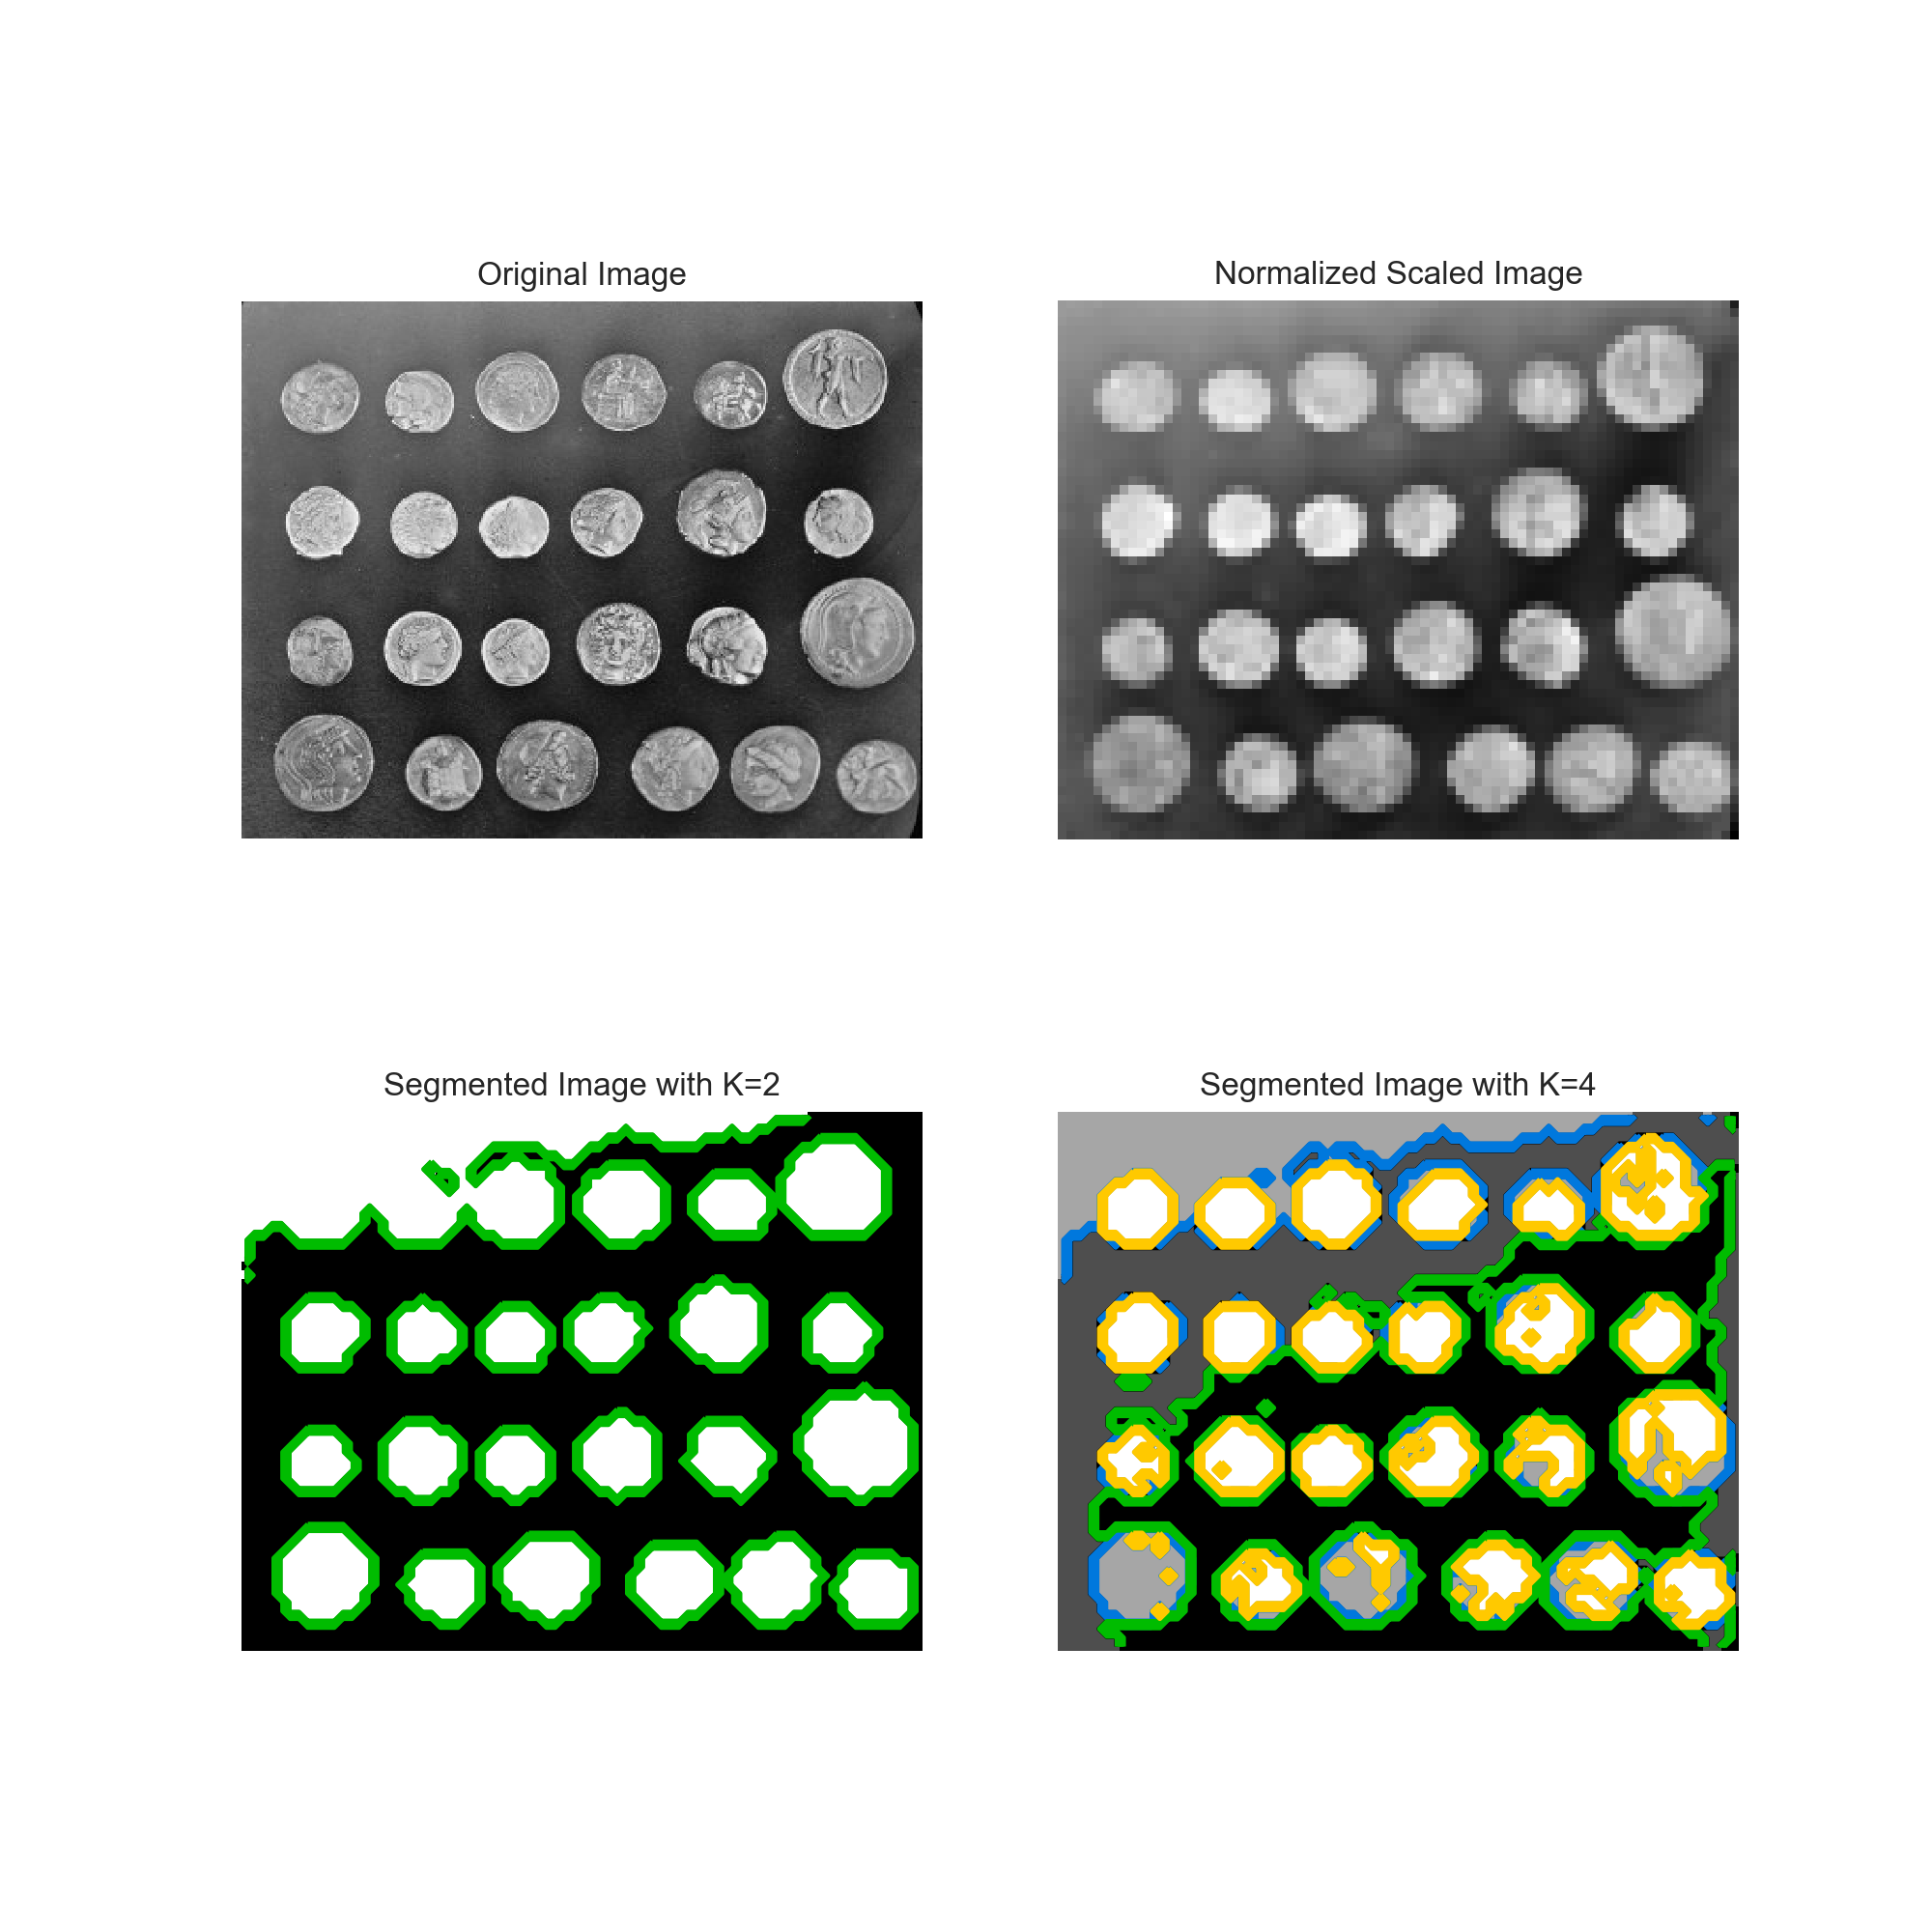

<IPython.core.display.Javascript object>


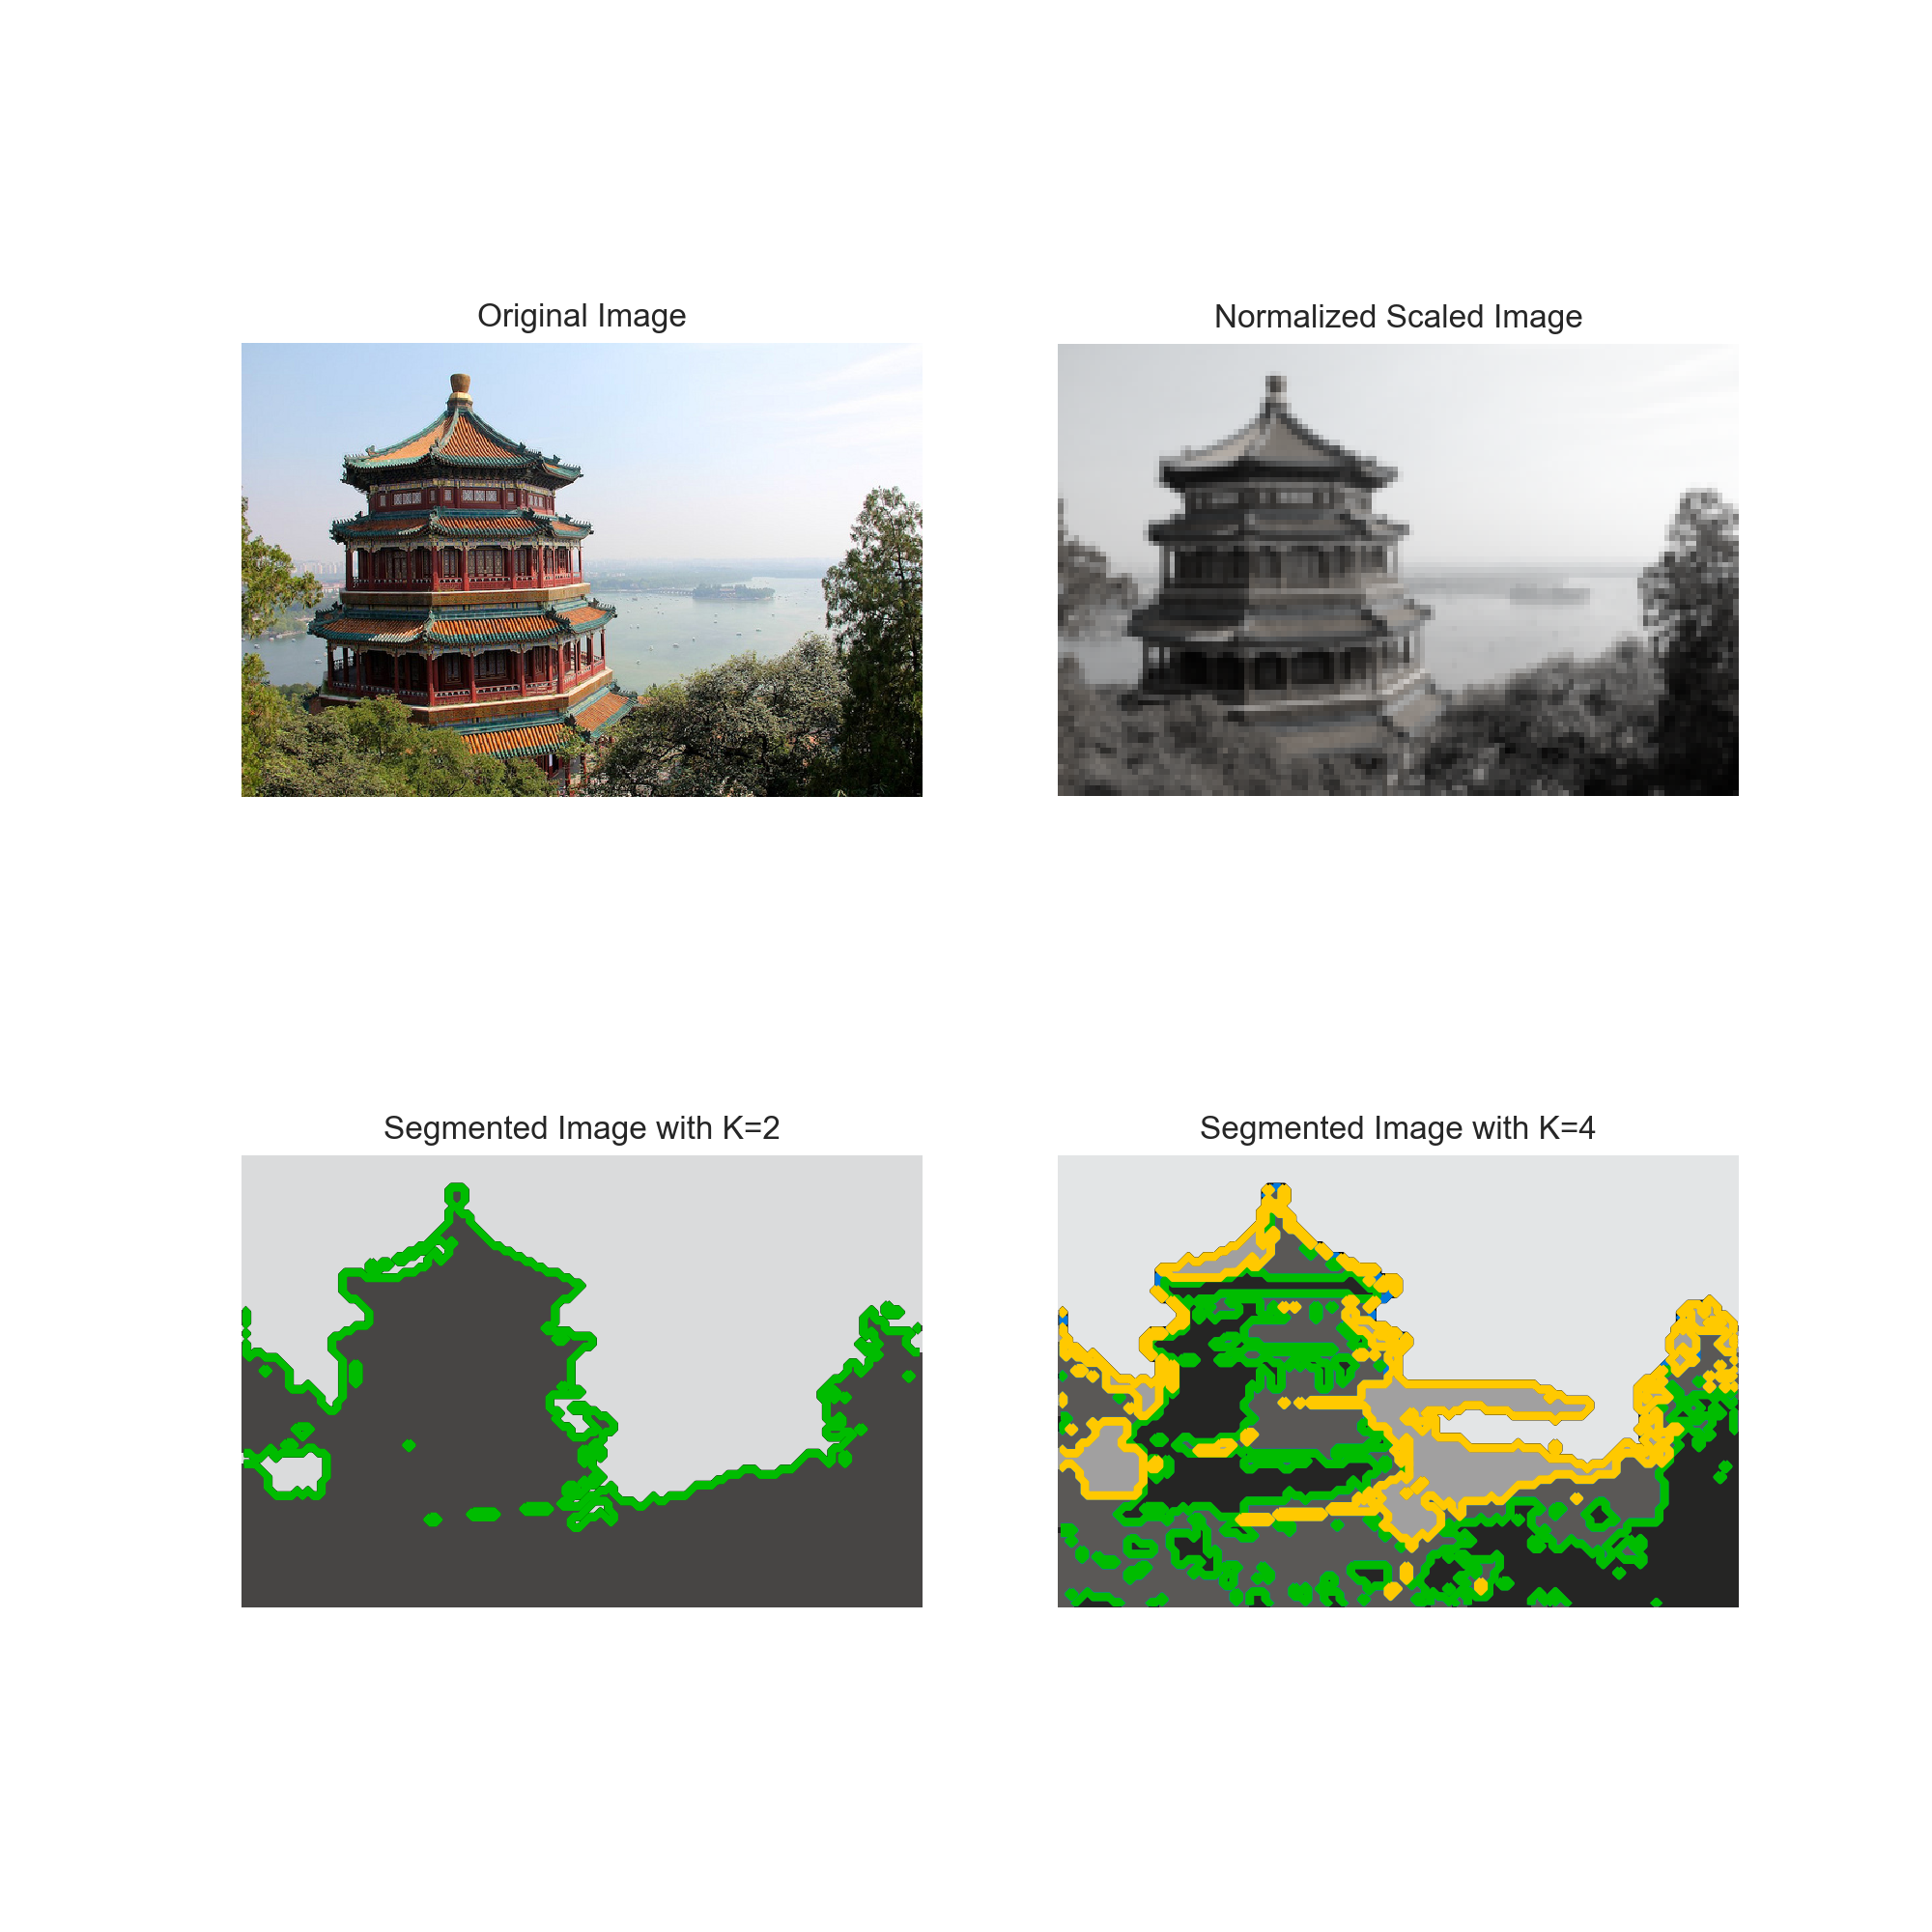

In [29]:
#https://dzone.com/articles/cluster-image-with-k-means

import time

def kmeans_segmentation(im, K = 10):

    im_dims = ImageUtils.dimensions(im)
    im_2d = ImageUtils.image_to_npimage(im, im_dims) 


    t0 = time.time()
    estimator = KMeans(n_clusters=K, random_state=42)
    estimator.fit(im_2d)
    labels = estimator.predict(im_2d)
    t1 = time.time()
    labels = estimator.labels_
    centers = estimator.cluster_centers_
    seg_im_2d = centers[labels]
    seg_im = ImageUtils.npimage_to_image(seg_im_2d, im_dims)

    return dict(image=seg_im, kmeans=estimator, labels=labels)
    

def demo_kmeans_segmentation(im_org, num_seg):
    im_norm = ImageUtils.normalize(im_org)
    im_norm_scale = ImageUtils.scaledown(im_norm)


    
    seg2kseg = {}
    image_infos=[
        {'image':im_org, 'title':'Original Image'},
        {'image':im_norm_scale, 'title':'Normalized Scaled Image'},
    ]    
    for num_seg in (2, 4,):
        ksegments = kmeans_segmentation(im_norm_scale, K = num_seg)  
        im_seg = ksegments['image']
        kmeans_seg = ksegments['kmeans']
        labels = ksegments['labels']
        seg2kseg[num_seg] = ksegments
        image_info = {
            'image':im_seg,
            'title': 'Segmented Image with K=%d' %(num_seg)
        }
        image_infos.append(image_info)
        
    cmap=plt.cm.gray
    axarr = ImageUtils.plot(cmap=cmap, ncols=2, width=10, height=10, 
                        image_infos=image_infos)

    axarru = axarr.ravel()
    cnt = 0
    for num_seg, ksegments  in seg2kseg.items():
        ksegments = seg2kseg[num_seg]
        labels = ksegments['labels']
        labels2 = labels.reshape(im_norm_scale.shape[0], im_norm_scale.shape[1])
        #print("labels2=", labels2.tolist())
        #print("cnt=", cnt, axarru.shape)
        seg_ax = axarru[2+cnt]
        
        for l in range(num_seg):
            seg_ax.contour(labels2 == l,
                       colors=[plt.cm.nipy_spectral(l / float(num_seg))])
        #print(labels.shape)
        cnt = cnt+1
    
    
    

# load the coins as a numpy array
im_coins = coins()
im_china = load_sample_image("china.jpg")

for im_org in (im_coins, im_china):  
#for im_org in (im_china):     
    demo_kmeans_segmentation(im_org, 2)
    

##### How to Choose K?

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

sqrt(number) of samples.
